# LSTM & GRU: Forecasting Guide for Financial Time Series
    Here I download the price time series of a publicly traded company from Yahoo Finance, covering the period from January 1st, 2018 to April 7th, 2025. Use the "Adjusted Close" prices to account for dividend payments.


## Início: Importando Bibliotecas e Baixando os Dados
    inclui visualização

[*********************100%***********************]  1 of 1 completed


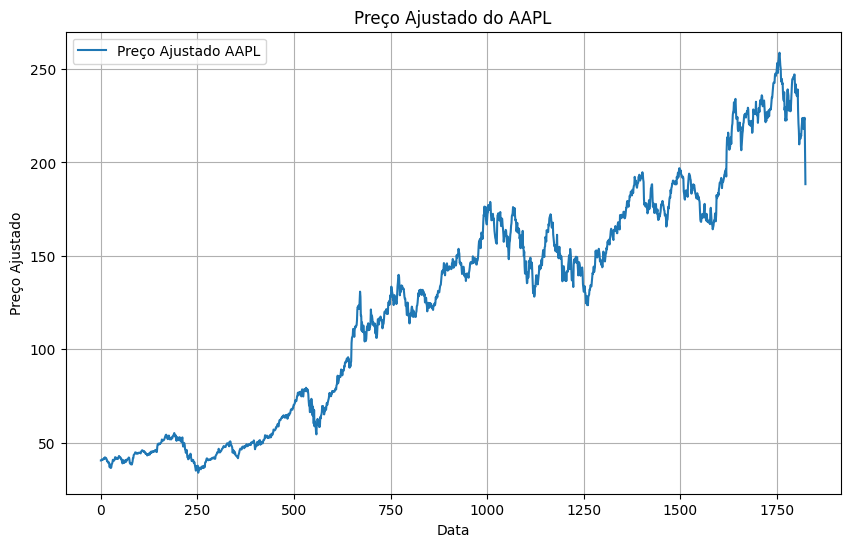

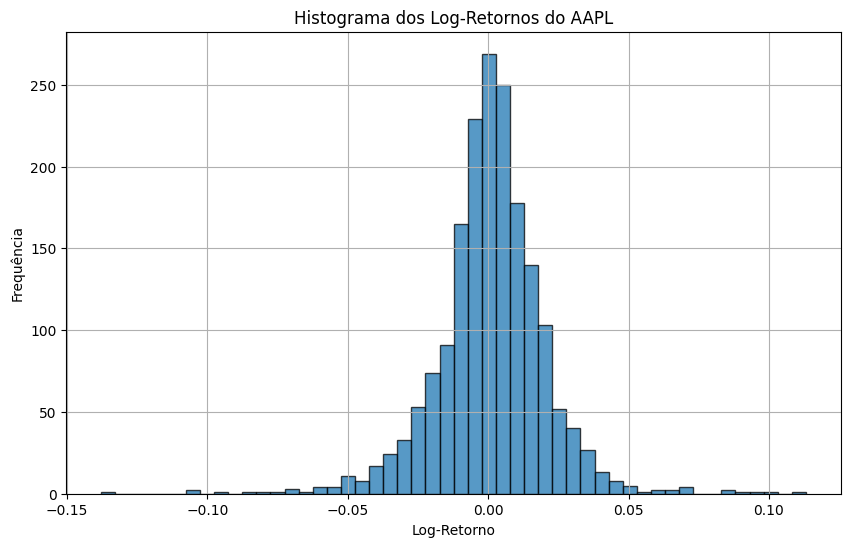

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd

class TimeSeriesAnalyzer:
    """-->download dos dados e serializacao ----------------
    """
    
    def __init__(self, ticker: str, start: str, end: str):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.data = None         # DataFrame do Polars com os dados baixados
        self.log_returns = None  # Vetor dos log-retornos da série
    
    def download_data(self):
        """atualmente, 10/abril/25
        adjust=True, os dados com colunas como strings representando tuplas.
        """
        df = yf.download(self.ticker, start=self.start, end=self.end, auto_adjust=True)
        self.data = pl.from_pandas(df)
        return self.data

    def _get_price_series(self) -> pd.Series:
        """ Deixei robusto para tuplas e multindex
        """
        df_pd = self.data.to_pandas()

        if isinstance(df_pd.columns[0], str) and df_pd.columns[0].startswith("('"): #ve se eh string
            # Procura por uma coluna que contenha "Close" e o ticker
            price_col = next((col for col in df_pd.columns # searcha o Close
                              if "Close" in col and self.ticker in col), None)
            if price_col is None:
                raise KeyError(f"Coluna 'Close' não encontrada para {self.ticker} dentre: {df_pd.columns}")
            return df_pd[price_col]
        elif isinstance(df_pd.columns, pd.MultiIndex):# -> MultiIndex: fatiamos (nível 'Price')
            try:
                price_df = df_pd.xs('Close', axis=1, level='Price')
            except KeyError:
                try:
                    price_df = df_pd.xs('Adj Close', axis=1, level='Price')
                except KeyError as e:
                    raise KeyError("Não foi possível fatiar o DataFrame pelo nível 'Price' com 'Close' ou 'Adj Close'. "
                                   f"Colunas disponíveis: {df_pd.columns}") from e
            if self.ticker in price_df.columns:
                return price_df[self.ticker]
            else:
                raise KeyError(f"Ticker {self.ticker} não encontrado nas colunas: {price_df.columns}")
        else:
            if 'Close' in df_pd.columns:
                return df_pd['Close']
            elif 'Adj Close' in df_pd.columns:
                return df_pd['Adj Close']
            else:
                raise KeyError("Nenhuma coluna de preço ajustado ('Close' ou 'Adj Close') encontrada no DataFrame")
    
    def plot_adj_close(self):
        df_pd = self.data.to_pandas()
        price_series = self._get_price_series()
        plt.figure(figsize=(10, 6))
        plt.plot(df_pd.index, price_series, label=f'Preço Ajustado {self.ticker}')
        plt.title(f"Preço Ajustado do {self.ticker}")
        plt.xlabel("Data")
        plt.ylabel("Preço Ajustado")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def compute_log_returns(self):
        """
        log_return(t) = ln(P(t) / P(t-1))
        """
        price_series = self._get_price_series()
        log_returns = np.log(price_series / price_series.shift(1))
        self.log_returns = log_returns.dropna()
        return self.log_returns

    def plot_log_returns_hist(self):
        """
        ########   log-retornos com 50 bins. ##############
        """
        plt.figure(figsize=(10, 6))
        plt.hist(self.log_returns, bins=50, alpha=0.75, edgecolor='black')
        plt.title(f"Histograma dos Log-Retornos do {self.ticker}")
        plt.xlabel("Log-Retorno")
        plt.ylabel("Frequência")
        plt.grid(True)
        plt.show()

#if __name__ == "__main__":   #para rodar em py ######################################
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2025-04-07"

analyzer = TimeSeriesAnalyzer(ticker, start_date, end_date) #obj def

analyzer.download_data()
analyzer.plot_adj_close()
analyzer.compute_log_returns()
analyzer.plot_log_returns_hist()


## Estatísticas Descritivas
    Mean, Max, Min, Std Deviation
    Skew, Kurtosis, Excess kurtosis
    Ljung-Box Test
    Jarque-Bera Test
    ARCH-LM Test

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Converta os log-retornos (que já foram calculados pelo analyzer) para um array 1D do numpy:
x = np.asarray(analyzer.log_returns)

n = x.shape[0]

# 1. Estatísticas Descritivas com NumPy
mean_val = np.mean(x)
max_val  = np.max(x)
min_val  = np.min(x)
std_val  = np.std(x, ddof=1)  # desvio padrão amostral

# Skewness e Kurtosis (kurtosis "excess" = kurtosis - 3)
skewness_val = np.mean((x - mean_val)**3) / (std_val**3)
kurtosis_val = np.mean((x - mean_val)**4) / (std_val**4)  # kurtosis não ajustada
excess_kurtosis = kurtosis_val - 3

# 2. Função para a CDF da distribuição qui-quadrado usando apenas numpy e math
def chi2_cdf(x_val, k):
    """
    Aproxima a CDF da distribuição qui-quadrado para um valor x_val e k graus de liberdade.
    Usamos o fato de que:
       CDF(x; k) = P(k/2, x/2) = (1 / Γ(k/2)) * ∫[0,x/2] t^(k/2 - 1) exp(-t) dt.
    Implementamos dois métodos: se x/2 < a+1, usamos expansão em série; 
    caso contrário, usamos a representação em fração contínua.
    """
    a = k/2.0
    x2 = x_val/2.0

    # Série para x2 < a+1
    if x2 < a + 1:
        term = 1.0 / a
        summation = term
        n_iter = 1
        while True:
            term *= x2 / (a + n_iter)
            summation += term
            if term < summation * 1e-8:
                break
            n_iter += 1
        return summation * math.exp(-x2 + a*math.log(x2) - math.lgamma(a))
    else:
        # Método da fração contínua
        ITMAX = 100
        EPS = 1e-8
        FPMIN = 1e-30

        b = x2 + 1 - a
        c = 1.0 / FPMIN
        d = 1.0 / b
        h = d
        for i in range(1, ITMAX+1):
            an = -i*(i - a)
            b += 2
            d = an * d + b
            if abs(d) < FPMIN:
                d = FPMIN
            c = b + an / c
            if abs(c) < FPMIN:
                c = FPMIN
            d = 1.0 / d
            delta = d * c
            h *= delta
            if abs(delta - 1.0) < EPS:
                break
        return 1.0 - math.exp(-x2 + a*math.log(x2) - math.lgamma(a)) * h

def chi2_sf(x_val, k):
    """Calcula a "survival function" (1-CDF) da qui-quadrado."""
    return 1.0 - chi2_cdf(x_val, k)

# 3. Ljung-Box Test (para 10 lags) utilizando apenas NumPy

def ljung_box_test(x_array, lags=10):
    N = len(x_array)
    mu = np.mean(x_array)
    denom = np.sum((x_array - mu)**2)
    acfs = []
    for k in range(1, lags+1):
        num = np.sum((x_array[k:] - mu) * (x_array[:-k] - mu))
        r_k = num / denom
        acfs.append(r_k)
    acfs = np.array(acfs)
    Q = N*(N+2)*np.sum(acfs**2 / (N - np.arange(1, lags+1)))
    p_value = chi2_sf(Q, lags)
    return Q, p_value

Q_lb, p_lb = ljung_box_test(x, lags=10)

# 4. Jarque-Bera Test utilizando apenas NumPy
# Formula: JB = n/6 * [ skewness^2 + ((kurtosis - 3)^2)/4 ]
JB = n/6.0 * (skewness_val**2 + ((kurtosis_val - 3)**2)/4.0)
p_jb = chi2_sf(JB, 2)  # df=2, já que o teste Jarque-Bera segue uma qui-quadrado de 2 graus de liberdade

# 5. ARCH-LM Test (Engle) com 10 lags usando apenas NumPy
def arch_lm_test(x_array, lags=10):
    # Testa a presença de efeitos ARCH nos quadrados dos log-retornos.
    # x_array: log-retornos
    # Calcula u_t^2
    x2 = x_array**2
    T = len(x2)
    if T <= lags:
        raise ValueError("A série precisa ter mais observações do que o número de lags")
    # Construindo a matriz de regressão
    # Para t = lags até T-1, cada linha: [1, x2[t-1], x2[t-2], ..., x2[t-lags]]
    X = np.ones((T - lags, lags + 1))
    for i in range(1, lags+1):
        X[:, i] = x2[lags - i:T - i]
    y = x2[lags:]
    # Estimar beta via OLS: beta = inv(X'X) X'y
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    # Previsões e R²
    y_hat = X.dot(beta)
    SSR = np.sum((y - y_hat)**2)
    SST = np.sum((y - np.mean(y))**2)
    R2 = 1.0 - SSR/SST
    LM = R2 * (T - lags)
    p_value = chi2_sf(LM, lags)
    return LM, p_value

LM_arch, p_arch = arch_lm_test(x, lags=10)

# Exibindo os resultados (usando formatação simples)
print("Estatísticas Descritivas (usando NumPy):")
print(f"Mean: {mean_val:.6f}")
print(f"Max: {max_val:.6f}")
print(f"Min: {min_val:.6f}")
print(f"Standard Deviation: {std_val:.6f}")
print(f"Skewness: {skewness_val:.6f}")
print(f"Kurtosis (raw): {kurtosis_val:.6f} --> Excess kurtosis: {excess_kurtosis:.6f}\n")

print("Ljung-Box Test (10 lags):")
print(f"Statistic: {Q_lb:.6f}, p-value: {p_lb:.2e}\n")

print("Jarque-Bera Test:")
print(f"Statistic: {JB:.6f}, p-value: {p_jb:.8e}\n")

print("ARCH-LM Test:")
print(f"LM Statistic: {LM_arch:.6f}, p-value: {p_arch:.8e}")



Estatísticas Descritivas (usando NumPy):
Mean: 0.000843
Max: 0.113158
Min: -0.137708
Standard Deviation: 0.019418
Skewness: -0.302264
Kurtosis (raw): 8.243980 --> Excess kurtosis: 5.243980

Ljung-Box Test (10 lags):
Statistic: 60.454671, p-value: 2.97e-09

Jarque-Bera Test:
Statistic: 2117.722984, p-value: 0.00000000e+00

ARCH-LM Test:
LM Statistic: 301.392816, p-value: 0.00000000e+00


## Regulando dados
    Normalização
    SEED
    Split 

In [11]:
import numpy as np

# 7. Definindo a semente para reprodutibilidade
SEED = 31415
np.random.seed(SEED)
print("Seed escolhida:", SEED)

# Extraindo a série de preços ajustados (como um array NumPy)
# Supondo que o seu objeto 'analyzer' já possui o método _get_price_series() que retorna uma pd.Series.
price_series = analyzer._get_price_series().values  # array 1D de preços

N = len(price_series)

# 5. Divisão da série em 70% treinamento, 20% validação, 10% teste
train_end = int(0.7 * N)
val_end   = train_end + int(0.2 * N)

train_series = price_series[:train_end]
val_series   = price_series[train_end:val_end]
test_series  = price_series[val_end:]

# 8. Normalização: usamos os valores mínimo e máximo do conjunto de treinamento para normalizar toda a série para [0, 1]
train_min = np.min(train_series)
train_max = np.max(train_series)

def normalize(series, min_val, max_val):
    return (series - min_val) / (max_val - min_val)

train_norm = normalize(train_series, train_min, train_max)
val_norm   = normalize(val_series, train_min, train_max)
test_norm  = normalize(test_series, train_min, train_max)

print("----------------------")
print("normalizacoes feitas: (valor - min_val) / (max_val - min_val) ")

# Função para criar janelas deslizantes (window_size = 24) para preparação dos dados
def create_sliding_windows(series, window_size=24, forecast_horizon=5):
    """
    Para uma série 1D, gera um array X com janelas de tamanho window_size 
    e um array y com os próximos forecast_horizon valores.
    """
    X = []
    y = []
    # Garantir que haja forecast_horizon valores após a janela
    for i in range(len(series) - window_size - forecast_horizon + 1):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

# Usando as variáveis já definidas: train_norm, val_norm, test_norm.
# Se você já tinha definido a divisão para previsão de um único passo, refaça agora para previsão de 5 passos.
forecast_horizon = 1
X_train, y_train = create_sliding_windows(train_norm, window_size=24, forecast_horizon=forecast_horizon)
X_val, y_val     = create_sliding_windows(val_norm, window_size=24, forecast_horizon=forecast_horizon)
X_test, y_test   = create_sliding_windows(test_norm, window_size=24, forecast_horizon=forecast_horizon)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)


print("----------------------")
print("divisoes dos conjuntos:")
print("Training: X =", X_train.shape, "y =", y_train.shape)
print("Validation: X =", X_val.shape, "y =", y_val.shape)
print("Testing: X =", X_test.shape, "y =", y_test.shape)


Seed escolhida: 31415
----------------------
normalizacoes feitas: (valor - min_val) / (max_val - min_val) 
----------------------
divisoes dos conjuntos:
Training: X = (1253, 24, 1) y = (1253, 1)
Validation: X = (341, 24, 1) y = (341, 1)
Testing: X = (159, 24, 1) y = (159, 1)


In [5]:
import numpy as np
import math

# Ativações e suas derivadas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(x.dtype)

# ==============================
# Camada LSTM
# ==============================
class LSTMLayer:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Os pesos são para a concatenação [h_{t-1}, x_t]
        concat_size = input_size + hidden_size
        
        # Inicialização dos pesos (divisão pela raiz do número de entradas, para estabilidade)
        self.W_f = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        self.W_i = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        self.W_o = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        self.W_c = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        
        self.b_f = np.zeros((hidden_size,))
        self.b_i = np.zeros((hidden_size,))
        self.b_o = np.zeros((hidden_size,))
        self.b_c = np.zeros((hidden_size,))
        
        # Parâmetros do Adam – para cada parâmetro
        self.mW_f = np.zeros_like(self.W_f); self.vW_f = np.zeros_like(self.W_f)
        self.mW_i = np.zeros_like(self.W_i); self.vW_i = np.zeros_like(self.W_i)
        self.mW_o = np.zeros_like(self.W_o); self.vW_o = np.zeros_like(self.W_o)
        self.mW_c = np.zeros_like(self.W_c); self.vW_c = np.zeros_like(self.W_c)
        
        self.mb_f = np.zeros_like(self.b_f); self.vb_f = np.zeros_like(self.b_f)
        self.mb_i = np.zeros_like(self.b_i); self.vb_i = np.zeros_like(self.b_i)
        self.mb_o = np.zeros_like(self.b_o); self.vb_o = np.zeros_like(self.b_o)
        self.mb_c = np.zeros_like(self.b_c); self.vb_c = np.zeros_like(self.b_c)
        
        self.t = 0  # contador para Adam
        
        # Para armazenar os valores do forward para o backprop
        self.cache = None

    def forward(self, X):
        """
        X: entrada com forma (batch, T, input_size)
        Retorna:
           H: sequência de saídas com forma (batch, T, hidden_size)
           h_last: última saída (batch, hidden_size)
        """
        batch, T, _ = X.shape
        h_t = np.zeros((batch, self.hidden_size))
        c_t = np.zeros((batch, self.hidden_size))
        self.cache = []  # guardar os valores de cada tempo

        H = np.zeros((batch, T, self.hidden_size))
        for t in range(T):
            x_t = X[:, t, :]  # (batch, input_size)
            concat = np.concatenate([h_t, x_t], axis=1)  # (batch, hidden_size+input_size)
            
            # Portões LSTM
            f_t_linear = np.dot(concat, self.W_f.T) + self.b_f
            i_t_linear = np.dot(concat, self.W_i.T) + self.b_i
            o_t_linear = np.dot(concat, self.W_o.T) + self.b_o
            c_tilde_linear = np.dot(concat, self.W_c.T) + self.b_c
            
            f_t = sigmoid(f_t_linear)
            i_t = sigmoid(i_t_linear)
            o_t = sigmoid(o_t_linear)
            c_tilde = tanh(c_tilde_linear)
            
            # Atualização do estado de célula e do estado oculto
            c_t = f_t * c_t + i_t * c_tilde
            h_t = o_t * tanh(c_t)
            
            H[:, t, :] = h_t
            # Guardar os valores para backprop
            self.cache.append({
                'concat': concat,
                'f_t': f_t, 'i_t': i_t, 'o_t': o_t, 'c_tilde': c_tilde,
                'c_t': c_t, 'h_t': h_t,
                'f_t_linear': f_t_linear, 'i_t_linear': i_t_linear,
                'o_t_linear': o_t_linear, 'c_tilde_linear': c_tilde_linear
            })
        self.h_last = h_t  # última saída
        return H, h_t

    def backward(self, dH):
        """
        dH: gradiente de perda em relação à saída H, com forma (batch, T, hidden_size).
        Aqui, implementamos um backpropagation simplificado
        que retropropaga apenas a partir do último passo temporal.
        Retorna:
           dX: gradiente em relação à entrada, forma (batch, T, input_size)
        OBS.: Esta implementação é simplificada e pode não representar
        corretamente todos os caminhos de gradiente através do tempo.
        """
        batch, T, _ = dH.shape
        dW_f = np.zeros_like(self.W_f)
        dW_i = np.zeros_like(self.W_i)
        dW_o = np.zeros_like(self.W_o)
        dW_c = np.zeros_like(self.W_c)
        db_f = np.zeros_like(self.b_f)
        db_i = np.zeros_like(self.b_i)
        db_o = np.zeros_like(self.b_o)
        db_c = np.zeros_like(self.b_c)
        
        dh_next = np.zeros((batch, self.hidden_size))
        dc_next = np.zeros((batch, self.hidden_size))
        dX = np.zeros((batch, T, self.input_size))
        
        # Retropropaga (simplificação: propagando do último tempo para trás)
        for t in reversed(range(T)):
            cache_t = self.cache[t]
            concat = cache_t['concat']
            f_t = cache_t['f_t']
            i_t = cache_t['i_t']
            o_t = cache_t['o_t']
            c_tilde = cache_t['c_tilde']
            c_t = cache_t['c_t']
            # Gradiente total em h_t
            dh = dH[:, t, :] + dh_next
            
            # Gradiente de h_t = o_t * tanh(c_t)
            do = dh * tanh(c_t)
            d_o_linear = do * dsigmoid(cache_t['o_t_linear'])
            
            # Gradiente que vem via c_t
            dc = dh * o_t * (1 - tanh(c_t)**2) + dc_next
            # Gradiente em c_t
            df = dc * (self.cache[t-1]['c_t'] if t > 0 else 0)
            d_f_linear = df * dsigmoid(cache_t['f_t_linear'])
            di = dc * c_tilde
            d_i_linear = di * dsigmoid(cache_t['i_t_linear'])
            dc_tilde = dc * i_t
            d_c_tilde_linear = dc_tilde * dtanh(cache_t['c_tilde_linear'])
            
            # Gradiente em concatenação
            dconcat = (np.dot(d_f_linear, self.W_f) +
                       np.dot(d_i_linear, self.W_i) +
                       np.dot(d_o_linear, self.W_o) +
                       np.dot(d_c_tilde_linear, self.W_c))
            
            # Acumula gradiente nos pesos
            dW_f += np.dot(d_f_linear.T, concat)
            dW_i += np.dot(d_i_linear.T, concat)
            dW_o += np.dot(d_o_linear.T, concat)
            dW_c += np.dot(d_c_tilde_linear.T, concat)
            db_f += np.sum(d_f_linear, axis=0)
            db_i += np.sum(d_i_linear, axis=0)
            db_o += np.sum(d_o_linear, axis=0)
            db_c += np.sum(d_c_tilde_linear, axis=0)
            
            # Separa gradiente em h_prev e x_t
            dh_next = dconcat[:, :self.hidden_size]
            dx = dconcat[:, self.hidden_size:]
            dX[:, t, :] = dx
            
            # Propaga o gradiente no estado da célula (simplificado)
            dc_next = dc * f_t
            
        # Armazenar os gradientes para atualizar os parâmetros
        self.dW_f, self.dW_i = dW_f, dW_i
        self.dW_o, self.dW_c = dW_o, dW_c
        self.db_f, self.db_i = db_f, db_i
        self.db_o, self.db_c = db_o, db_c
        
        return dX

    def update_parameters(self, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        # Atualização Adam para cada conjunto de parâmetros
        for param, dparam, m, v in [
            (self.W_f, self.dW_f, 'mW_f', 'vW_f'),
            (self.W_i, self.dW_i, 'mW_i', 'vW_i'),
            (self.W_o, self.dW_o, 'mW_o', 'vW_o'),
            (self.W_c, self.dW_c, 'mW_c', 'vW_c')
        ]:
            m_val = getattr(self, m)
            v_val = getattr(self, v)
            m_val = beta1 * m_val + (1 - beta1) * dparam
            v_val = beta2 * v_val + (1 - beta2) * (dparam**2)
            m_hat = m_val / (1 - beta1**self.t)
            v_hat = v_val / (1 - beta2**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)
            setattr(self, m, m_val)
            setattr(self, v, v_val)
            
        # Atualização para os vieses
        for param, dparam, m_name, v_name in [
            (self.b_f, self.db_f, 'mb_f', 'vb_f'),
            (self.b_i, self.db_i, 'mb_i', 'vb_i'),
            (self.b_o, self.db_o, 'mb_o', 'vb_o'),
            (self.b_c, self.db_c, 'mb_c', 'vb_c')
        ]:
            m_val = getattr(self, m_name, np.zeros_like(param))
            v_val = getattr(self, v_name, np.zeros_like(param))
            m_val = beta1 * m_val + (1 - beta1) * dparam
            v_val = beta2 * v_val + (1 - beta2) * (dparam**2)
            m_hat = m_val / (1 - beta1**self.t)
            v_hat = v_val / (1 - beta2**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)
            setattr(self, m_name, m_val)
            setattr(self, v_name, v_val)

# ==============================
# Camada Dense
# ==============================
class Dense:
    def __init__(self, input_size, output_size, activation='relu'):
        self.W = np.random.randn(input_size, output_size) / np.sqrt(input_size)
        self.b = np.zeros((1, output_size))
        self.activation = activation
        
        # Parâmetros Adam
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        self.t = 0

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) + self.b
        if self.activation == 'relu':
            self.A = relu(self.Z)
        else:
            self.A = self.Z  # linear
        return self.A

    def backward(self, dA):
        if self.activation == 'relu':
            dZ = dA * drelu(self.Z)
        else:
            dZ = dA
        self.dW = np.dot(self.X.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dX

    def update_parameters(self, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        self.mW = beta1 * self.mW + (1 - beta1) * self.dW
        self.vW = beta2 * self.vW + (1 - beta2) * (self.dW**2)
        mW_hat = self.mW / (1 - beta1**self.t)
        vW_hat = self.vW / (1 - beta2**self.t)
        self.W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
        
        self.mb = beta1 * self.mb + (1 - beta1) * self.db
        self.vb = beta2 * self.vb + (1 - beta2) * (self.db**2)
        mb_hat = self.mb / (1 - beta1**self.t)
        vb_hat = self.vb / (1 - beta2**self.t)
        self.b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)

# ==============================
# Modelo LSTM completo
# ==============================
class LSTMModel:
    def __init__(self, input_size, lstm_hidden1, lstm_hidden2, output_size):
        # Primeira camada LSTM: processa a entrada
        self.lstm1 = LSTMLayer(input_size, lstm_hidden1)
        # Segunda camada LSTM: processa a saída da primeira
        self.lstm2 = LSTMLayer(lstm_hidden1, lstm_hidden2)
        # Camada densa de saída (para regressão, usamos ativação linear)
        self.dense = Dense(lstm_hidden2, output_size, activation='linear')
    
    def forward(self, X):
        # X: (batch, T, input_size)
        H1, _ = self.lstm1.forward(X)
        H2, _ = self.lstm2.forward(H1)
        # Utilizamos a última saída temporal da segunda camada LSTM
        self.h_last = H2[:, -1, :]  # (batch, lstm_hidden2)
        out = self.dense.forward(self.h_last)
        return out
    
    def compute_loss(self, y_pred, y_true):
        # Loss: Mean Squared Error
        loss = np.mean((y_pred - y_true)**2)
        return loss
    
    def backward(self, y_pred, y_true):
        # Gradiente da MSE: (2/N)*(y_pred - y_true)
        batch = y_true.shape[0]
        dLoss = 2*(y_pred - y_true) / batch  # (batch, output_size)
        # Backprop na camada densa
        d_dense = self.dense.backward(dLoss)
        # Propagar gradiente para a segunda camada LSTM
        # (aqui, simplificamos propagando o gradiente apenas para o último tempo)
        T2 = len(self.lstm2.cache)
        dH2 = np.zeros((batch, T2, self.lstm2.hidden_size))
        dH2[:, -1, :] = d_dense  # gradiente somente no último tempo
        dX2 = self.lstm2.backward(dH2)
        # Propagar para a primeira camada LSTM
        dX1 = self.lstm1.backward(dX2)
        # (Não precisamos retornar dX1 para a entrada)
    
    def update_parameters(self, lr):
        self.lstm1.update_parameters(lr)
        self.lstm2.update_parameters(lr)
        self.dense.update_parameters(lr)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20):
        self.train_history = {"train_loss": [], "val_loss": []}
        best_val_loss = float('inf')
        patience_counter = 0
        num_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            # Embaralhar os dados de treinamento para cada época
            permutation = np.random.permutation(num_samples)
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]
            epoch_loss = 0
            
            # Treinamento em batches
            for i in range(0, num_samples, batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                epoch_loss += loss
                
                # Backward pass e atualização
                self.backward(y_pred, y_batch)
                self.update_parameters(lr)
            
            epoch_loss /= (num_samples / batch_size)
            # Validação
            y_val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val_pred, y_val)
            print(f"Epoch {epoch+1:03d} | Training Loss: {epoch_loss:.6f} | Validation Loss: {val_loss:.6f}")
            self.train_history["train_loss"].append(epoch_loss)
            self.train_history["val_loss"].append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered at epoch", epoch+1)
                break

# ==============================
# Exemplo de uso
# ==============================
# Supondo que X_train, y_train, X_val, y_val tenham sido preparados (por ex., via sliding window)
# Onde X tem forma (num_samples, 24, 1) e y tem forma (num_samples, 1)
# Definindo o modelo:
input_size = 1       # série univariada
lstm_hidden1 = 64
lstm_hidden2 = 32
output_size = 1

lstm_model = LSTMModel(input_size, lstm_hidden1, lstm_hidden2, output_size)

# Treinamento (os conjuntos X_train, y_train, X_val, y_val devem estar previamente definidos)
lstm_model.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20)


Epoch 001 | Training Loss: 0.094222 | Validation Loss: 0.003732
Epoch 002 | Training Loss: 0.003809 | Validation Loss: 0.002122
Epoch 003 | Training Loss: 0.001400 | Validation Loss: 0.002315
Epoch 004 | Training Loss: 0.001174 | Validation Loss: 0.003805
Epoch 005 | Training Loss: 0.001087 | Validation Loss: 0.006454
Epoch 006 | Training Loss: 0.001077 | Validation Loss: 0.005423
Epoch 007 | Training Loss: 0.001014 | Validation Loss: 0.006971
Epoch 008 | Training Loss: 0.000972 | Validation Loss: 0.004769
Epoch 009 | Training Loss: 0.000944 | Validation Loss: 0.005077
Epoch 010 | Training Loss: 0.000908 | Validation Loss: 0.004186
Epoch 011 | Training Loss: 0.000869 | Validation Loss: 0.004565
Epoch 012 | Training Loss: 0.000841 | Validation Loss: 0.004698
Epoch 013 | Training Loss: 0.000795 | Validation Loss: 0.003447
Epoch 014 | Training Loss: 0.000835 | Validation Loss: 0.002405
Epoch 015 | Training Loss: 0.000737 | Validation Loss: 0.005352
Epoch 016 | Training Loss: 0.000821 | Va

In [6]:
# (VOU REDEFINIR PARA PODER EXECUTAR SEPARADAMENTE)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)
def relu(x):
    return np.maximum(0, x)
def drelu(x):
    return (x > 0).astype(x.dtype)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # 
class GRULayer:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        # gates de atualização (z) e reset (r), o input é a concatenação de h_prev e x_t
        concat_size = input_size + hidden_size
        self.W_z = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        self.b_z = np.zeros((hidden_size,))
        self.W_r = np.random.randn(hidden_size, concat_size) / np.sqrt(concat_size)
        self.b_r = np.zeros((hidden_size,))
        # Para o candidato, a entrada será a concatenação de (r * h_prev) e x_t.
        candidate_input_size = hidden_size + input_size
        self.W_h = np.random.randn(hidden_size, candidate_input_size) / np.sqrt(candidate_input_size)
        self.b_h = np.zeros((hidden_size,))
        
        # Parâmetros para Adam para cada conjunto de pesos
        self.mW_z = np.zeros_like(self.W_z); self.vW_z = np.zeros_like(self.W_z)
        self.mb_z = np.zeros_like(self.b_z); self.vb_z = np.zeros_like(self.b_z)
        self.mW_r = np.zeros_like(self.W_r); self.vW_r = np.zeros_like(self.W_r)
        self.mb_r = np.zeros_like(self.b_r); self.vb_r = np.zeros_like(self.b_r)
        self.mW_h = np.zeros_like(self.W_h); self.vW_h = np.zeros_like(self.W_h)
        self.mb_h = np.zeros_like(self.b_h); self.vb_h = np.zeros_like(self.b_h)
        
        self.t = 0  # contador de iterações para Adam
        self.cache = None  # para armazenar valores do forward para o backward

    def forward(self, X):
        """
        X: entrada com shape (batch, T, input_size)
        Retorna:
           H: todas as saídas, shape (batch, T, hidden_size)
           h_last: última saída, shape (batch, hidden_size)
        """
        batch, T, _ = X.shape
        h_t = np.zeros((batch, self.hidden_size))
        self.cache = []  # para guardar o cache de cada tempo
        
        H = np.zeros((batch, T, self.hidden_size))
        for t in range(T):
            x_t = X[:, t, :]  # (batch, input_size)
            # Concatenação do estado anterior com a entrada
            concat = np.concatenate([h_t, x_t], axis=1)  # (batch, hidden_size + input_size)
            
            # Portão de atualização
            z_linear = np.dot(concat, self.W_z.T) + self.b_z  # (batch, hidden_size)
            z_t = sigmoid(z_linear)
            
            # Portão de reset
            r_linear = np.dot(concat, self.W_r.T) + self.b_r
            r_t = sigmoid(r_linear)
            
            # Candidato: multiplicamos elemento a elemento o reset gate com h_t
            candidate_input = np.concatenate([r_t * h_t, x_t], axis=1)  # (batch, hidden_size + input_size)
            h_candidate_linear = np.dot(candidate_input, self.W_h.T) + self.b_h
            # Aplicando ReLU, conforme especificado
            h_candidate = relu(h_candidate_linear)
            
            # Nova saída: combinação ponderada entre h_t e h_candidate, conforme o portão de atualização
            h_new = (1 - z_t) * h_t + z_t * h_candidate
            
            # Salva no cache os valores necessários para o backward
            self.cache.append({
                'h_prev': h_t, 'x_t': x_t, 'concat': concat,
                'z_t': z_t, 'z_linear': z_linear,
                'r_t': r_t, 'r_linear': r_linear,
                'candidate_input': candidate_input,
                'h_candidate': h_candidate,
                'h_candidate_linear': h_candidate_linear,
                'h_new': h_new
            })
            h_t = h_new
            H[:, t, :] = h_t
        self.h_last = h_t
        return H, h_t

    def backward(self, dH):
        """
        dH: gradiente da perda em relação à saída H com shape (batch, T, hidden_size)
        Esta implementação realiza uma retropropagação simplificada (por tempo reverso) 
        que se baseia, principalmente, no gradiente do último tempo.
        Retorna:
           dX: gradiente em relação à entrada, shape (batch, T, input_size)
        """
        batch, T, _ = dH.shape
        dW_z = np.zeros_like(self.W_z)
        dW_r = np.zeros_like(self.W_r)
        dW_h = np.zeros_like(self.W_h)
        db_z = np.zeros_like(self.b_z)
        db_r = np.zeros_like(self.b_r)
        db_h = np.zeros_like(self.b_h)
        
        dh_next = np.zeros((batch, self.hidden_size))
        dX = np.zeros((batch, T, self.input_size))
        
        # Retropropaga de trás para frente (simplificado)
        for t in reversed(range(T)):
            cache_t = self.cache[t]
            h_prev = cache_t['h_prev']         # (batch, hidden_size)
            x_t = cache_t['x_t']               # (batch, input_size)
            concat = cache_t['concat']         # (batch, hidden_size+input_size)
            z_t = cache_t['z_t']               # (batch, hidden_size)
            z_linear = cache_t['z_linear']
            r_t = cache_t['r_t']               # (batch, hidden_size)
            r_linear = cache_t['r_linear']
            candidate_input = cache_t['candidate_input'] # (batch, hidden_size+input_size)
            h_candidate = cache_t['h_candidate']
            h_candidate_linear = cache_t['h_candidate_linear']
            h_new = cache_t['h_new']           # (batch, hidden_size)
            
            # Gradiente total para h_new: proveniente da loss (dH) e do fluxo de gradiente (dh_next)
            dht = dH[:, t, :] + dh_next
            
            # Para a equação: h_new = (1-z_t) * h_prev + z_t * h_candidate,
            # derivadas parciais:
            dz = dht * (h_candidate - h_prev)        # (batch, hidden_size)
            dh_candidate = dht * z_t                   # (batch, hidden_size)
            dh_prev = dht * (1 - z_t)                  # (batch, hidden_size)
            
            # Backprop candidato (ReLU)
            d_h_candidate_linear = dh_candidate * drelu(h_candidate_linear)  # (batch, hidden_size)
            dW_h += np.dot(d_h_candidate_linear.T, candidate_input)
            db_h += np.sum(d_h_candidate_linear, axis=0)
            d_candidate_input = np.dot(d_h_candidate_linear, self.W_h)  # (batch, hidden_size+input_size)
            # Dividindo o gradiente da candidate_input
            d_part1 = d_candidate_input[:, :self.hidden_size]  # relacionado a r_t * h_prev
            d_part2 = d_candidate_input[:, self.hidden_size:]   # relacionado a x_t
            
            # Gradiente para r_t (do ramo candidato)
            dr_from_candidate = d_part1 * h_prev  # (batch, hidden_size)
            # Atualize o gradiente em h_prev via candidato
            dh_prev += d_part1 * r_t
            
            # Backprop pelo portão reset
            dr = dr_from_candidate
            dr_linear = dr * dsigmoid(r_linear)
            dW_r += np.dot(dr_linear.T, concat)
            db_r += np.sum(dr_linear, axis=0)
            dconcat_r = np.dot(dr_linear, self.W_r)
            
            # Backprop pelo portão de atualização
            dz_linear = dz * dsigmoid(z_linear)
            dW_z += np.dot(dz_linear.T, concat)
            db_z += np.sum(dz_linear, axis=0)
            dconcat_z = np.dot(dz_linear, self.W_z)
            
            # Soma dos gradientes que recaem sobre o vetor "concat"
            dconcat = dconcat_r + dconcat_z
            # "concat" = [h_prev, x_t]
            dh_prev += dconcat[:, :self.hidden_size]
            dx = dconcat[:, self.hidden_size:] + d_part2
            
            dX[:, t, :] = dx
            dh_next = dh_prev  # propaga para o tempo anterior
            
        # Armazena os gradientes para atualização dos parâmetros via Adam
        self.dW_z, self.dW_r, self.dW_h = dW_z, dW_r, dW_h
        self.db_z, self.db_r, self.db_h = db_z, db_r, db_h
        return dX

    def update_parameters(self, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        # Atualização dos pesos dos portões z, r e do candidato (W_h)
        for param, dparam, m, v in [
            (self.W_z, self.dW_z, 'mW_z', 'vW_z'),
            (self.W_r, self.dW_r, 'mW_r', 'vW_r'),
            (self.W_h, self.dW_h, 'mW_h', 'vW_h')
        ]:
            m_val = getattr(self, m)
            v_val = getattr(self, v)
            m_val = beta1 * m_val + (1 - beta1) * dparam
            v_val = beta2 * v_val + (1 - beta2) * (dparam**2)
            m_hat = m_val / (1 - beta1**self.t)
            v_hat = v_val / (1 - beta2**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)
            setattr(self, m, m_val)
            setattr(self, v, v_val)
            
        for param, dparam, m, v in [
            (self.b_z, self.db_z, 'mb_z', 'vb_z'),
            (self.b_r, self.db_r, 'mb_r', 'vb_r'),
            (self.b_h, self.db_h, 'mb_h', 'vb_h')
        ]:
            m_val = getattr(self, m, np.zeros_like(param))
            v_val = getattr(self, v, np.zeros_like(param))
            m_val = beta1 * m_val + (1 - beta1) * dparam
            v_val = beta2 * v_val + (1 - beta2) * (dparam**2)
            m_hat = m_val / (1 - beta1**self.t)
            v_hat = v_val / (1 - beta2**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)
            setattr(self, m, m_val)
            setattr(self, v, v_val)

class Dense:
    def __init__(self, input_size, output_size, activation='relu'):
        self.W = np.random.randn(input_size, output_size) / np.sqrt(input_size)
        self.b = np.zeros((1, output_size))
        self.activation = activation
        
        # args p/ Adam
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        self.t = 0

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) + self.b
        if self.activation == 'relu':
            self.A = relu(self.Z)
        else:
            self.A = self.Z  # ativ lin
        return self.A

    def backward(self, dA):
        if self.activation == 'relu':
            dZ = dA * drelu(self.Z)
        else:
            dZ = dA
        self.dW = np.dot(self.X.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dX

    def update_parameters(self, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        self.mW = beta1 * self.mW + (1 - beta1) * self.dW
        self.vW = beta2 * self.vW + (1 - beta2) * (self.dW**2)
        mW_hat = self.mW / (1 - beta1**self.t)
        vW_hat = self.vW / (1 - beta2**self.t)
        self.W -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
        
        self.mb = beta1 * self.mb + (1 - beta1) * self.db
        self.vb = beta2 * self.vb + (1 - beta2) * (self.db**2)
        mb_hat = self.mb / (1 - beta1**self.t)
        vb_hat = self.vb / (1 - beta2**self.t)
        self.b -= lr * mb_hat / (np.sqrt(vb_hat) + eps)

################### Classe Principal  ###################################
class GRUModel:
    def __init__(self, input_size, gru_hidden1, gru_hidden2, output_size):
        self.gru1 = GRULayer(input_size, gru_hidden1)
        self.gru2 = GRULayer(gru_hidden1, gru_hidden2)
        # Camada de saída com ativação linear (para regressão)
        self.dense = Dense(gru_hidden2, output_size, activation='linear')
    
    def forward(self, X):
        # X: (batch, T, input_size)
        H1, _ = self.gru1.forward(X)
        H2, _ = self.gru2.forward(H1)
        # Usamos a última saída temporal da segunda camada GRU
        self.h_last = H2[:, -1, :]  # (batch, gru_hidden2)
        out = self.dense.forward(self.h_last)
        return out
    
    def compute_loss(self, y_pred, y_true):
        # Loss MSE
        loss = np.mean((y_pred - y_true)**2)
        return loss
    
    def backward(self, y_pred, y_true):
        batch = y_true.shape[0]
        dLoss = 2 * (y_pred - y_true) / batch  # (batch, output_size)
        # Backprop na camada densa
        d_dense = self.dense.backward(dLoss)
        # Propagar gradiente para a segunda camada GRU: aplicamos o gradiente apenas no último tempo
        T2 = len(self.gru2.cache)
        dH2 = np.zeros((batch, T2, self.gru2.hidden_size))
        dH2[:, -1, :] = d_dense
        dX2 = self.gru2.backward(dH2)
        # Propaga para a primeira camada GRU
        _ = self.gru1.backward(dX2)
    
    def update_parameters(self, lr):
        self.gru1.update_parameters(lr)
        self.gru2.update_parameters(lr)
        self.dense.update_parameters(lr)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20):
        self.train_history = {"train_loss": [], "val_loss": []}

        best_val_loss = float('inf')
        patience_counter = 0
        num_samples = X_train.shape[0]
        
        for epoch in range(epochs):
            permutation = np.random.permutation(num_samples)
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]
            epoch_loss = 0
            
            for i in range(0, num_samples, batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                epoch_loss += loss
                
                # Backward pass e atualização
                self.backward(y_pred, y_batch)
                self.update_parameters(lr)
            
            epoch_loss /= (num_samples / batch_size)
            # Validação
            y_val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val_pred, y_val)
            print(f"Epoch {epoch+1:03d} | Training Loss: {epoch_loss:.6f} | Validation Loss: {val_loss:.6f}")
            self.train_history["train_loss"].append(epoch_loss)
            self.train_history["val_loss"].append(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered at epoch", epoch+1)
                break

# ==============================
# Exemplo de uso do model2 (GRU)
# ==============================
# Suponha que os conjuntos X_train, y_train, X_val, y_val já estejam preparados,
# com X com shape (num_samples, time_steps, 1) e y com shape (num_samples, 1).
# Parâmetros:
input_size = 1       # série univariada
gru_hidden1 = 64
gru_hidden2 = 32
output_size = 1

gru_model = GRUModel(input_size, gru_hidden1, gru_hidden2, output_size)

# Para treinar, certifique-se de que seus dados tenham as shapes corretas.
# Exemplo:
gru_model.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20)


Epoch 001 | Training Loss: 0.117945 | Validation Loss: 0.033169
Epoch 002 | Training Loss: 0.008083 | Validation Loss: 0.002663
Epoch 003 | Training Loss: 0.001146 | Validation Loss: 0.002556
Epoch 004 | Training Loss: 0.000787 | Validation Loss: 0.001401
Epoch 005 | Training Loss: 0.000642 | Validation Loss: 0.001848
Epoch 006 | Training Loss: 0.000620 | Validation Loss: 0.000758
Epoch 007 | Training Loss: 0.000513 | Validation Loss: 0.000708
Epoch 008 | Training Loss: 0.000511 | Validation Loss: 0.000733
Epoch 009 | Training Loss: 0.000477 | Validation Loss: 0.000780
Epoch 010 | Training Loss: 0.000458 | Validation Loss: 0.000698
Epoch 011 | Training Loss: 0.000489 | Validation Loss: 0.000594
Epoch 012 | Training Loss: 0.000456 | Validation Loss: 0.000818
Epoch 013 | Training Loss: 0.000465 | Validation Loss: 0.000911
Epoch 014 | Training Loss: 0.000450 | Validation Loss: 0.000578
Epoch 015 | Training Loss: 0.000421 | Validation Loss: 0.000894
Epoch 016 | Training Loss: 0.000389 | Va

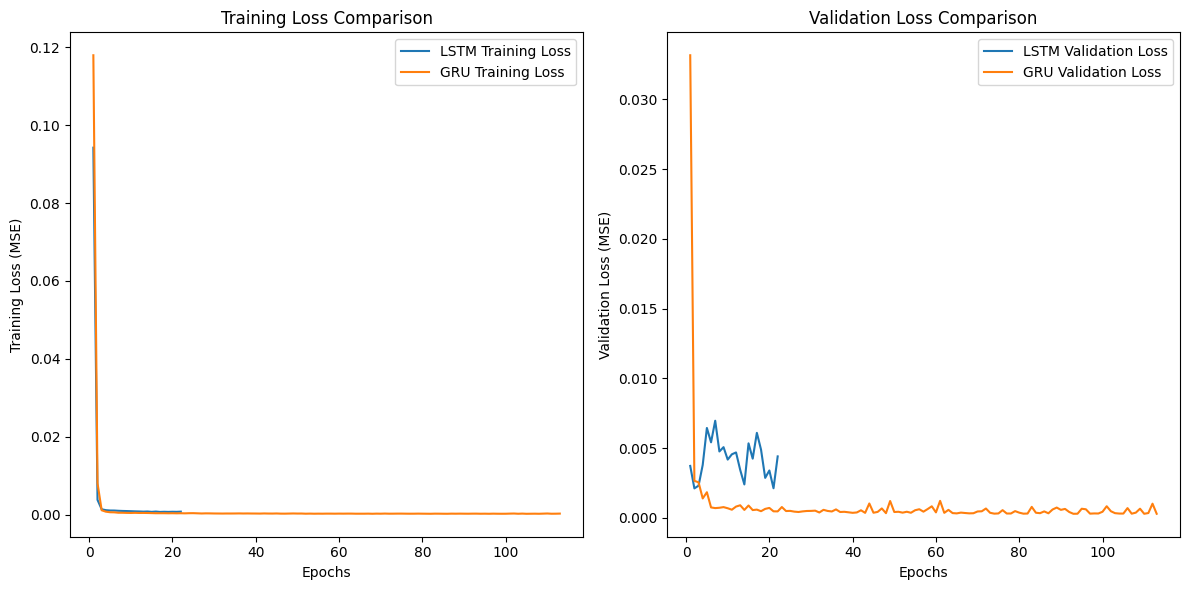

Validation Metrics:
LSTM -> MSE: 92.787985, MAE: 8.330330, MAPE: 4.49%
GRU  -> MSE: 6.373796, MAE: 1.853781, MAPE: 1.02%

Test Metrics:
LSTM -> MSE: 470.783187, MAE: 20.953038, MAPE: 9.00%
GRU  -> MSE: 16.366649, MAE: 2.990123, MAPE: 1.31%


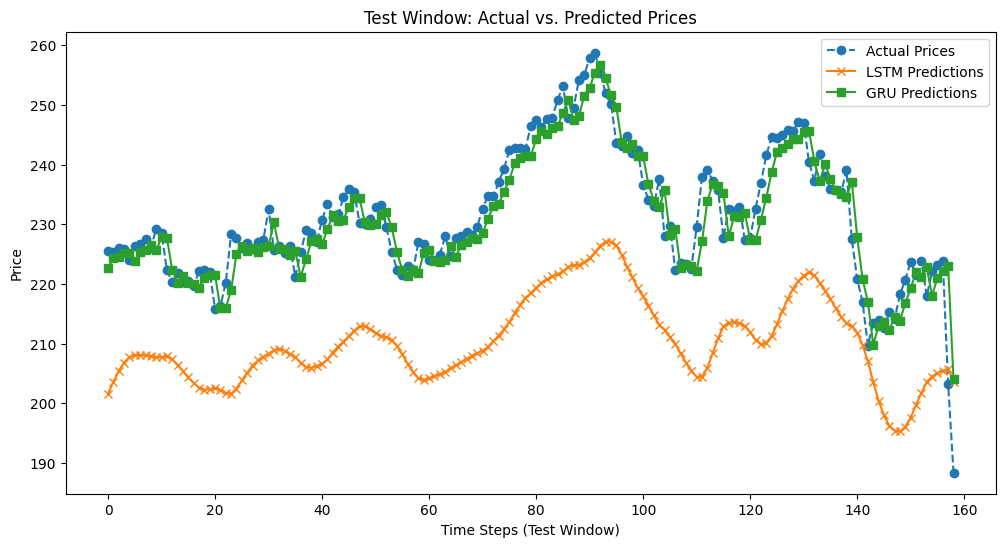

Out-of-Sample Forecast (first 10 predictions):
LSTM: [203.64274172 200.54768253 196.83062185 192.806531   188.70867057
 184.68981941 180.88486501 177.34424998 174.09590036 171.15997862]
GRU:  [204.1012659  203.75094184 203.77912877 203.43138243 203.09840149
 202.79877331 202.51393005 202.23884736 201.96977777 201.7062498 ]


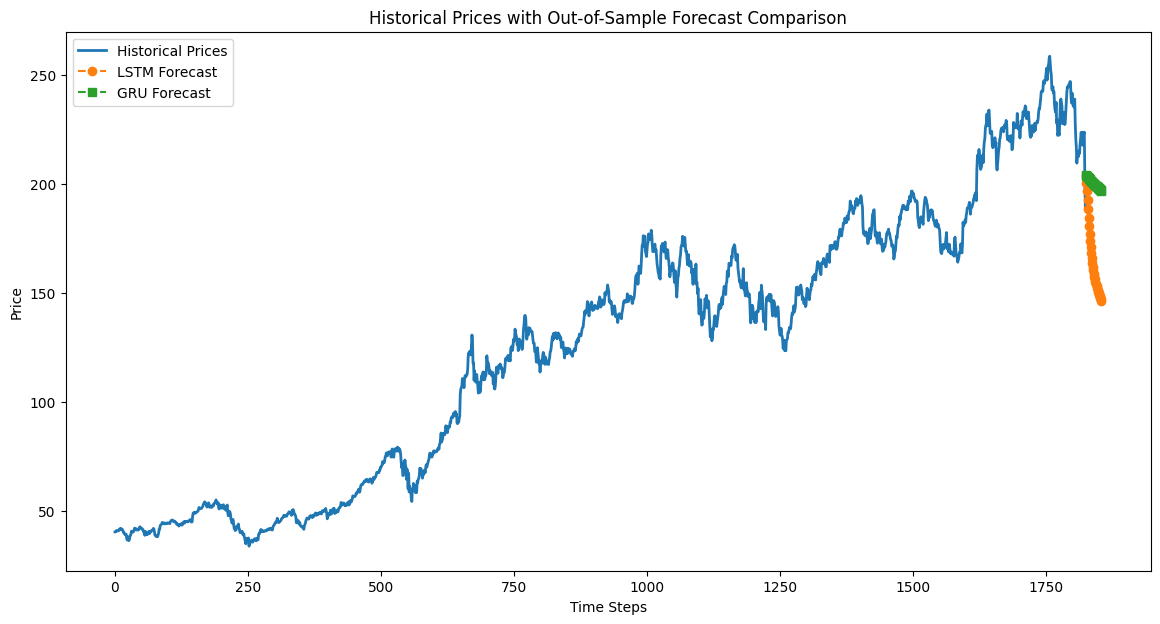

In [7]:
import numpy as np
import matplotlib.pyplot as plt

###############################################
# Funções Auxiliares
###############################################

# Função inversa da normalização
def denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val) + min_val

# Função para normalização (caso não esteja definida)
def normalize(series, min_val, max_val):
    return (series - min_val) / (max_val - min_val)

# Função para calcular métricas (MSE, MAE, MAPE)
def compute_metrics(true, pred):
    mse = np.mean((true - pred)**2)
    mae = np.mean(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred)/true)) * 100  # em porcentagem
    return mse, mae, mape

###############################################
# 11. Comparando o histórico de treinamento
###############################################

# Supondo que ambos os modelos armazenam o histórico em um dicionário "train_history"
# Cria os vetores de epochs para cada modelo
epochs_lstm = np.arange(1, len(lstm_model.train_history["train_loss"]) + 1)
epochs_gru  = np.arange(1, len(gru_model.train_history["train_loss"]) + 1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs_lstm, lstm_model.train_history["train_loss"], label="LSTM Training Loss")
plt.plot(epochs_gru, gru_model.train_history["train_loss"], label="GRU Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Comparison")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_lstm, lstm_model.train_history["val_loss"], label="LSTM Validation Loss")
plt.plot(epochs_gru, gru_model.train_history["val_loss"], label="GRU Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss Comparison")
plt.legend()

plt.tight_layout()
plt.show()


###############################################
# 12. Denormalizar previsões e calcular métricas para Validação e Teste
###############################################

# Obter previsões dos dois modelos (assegure que X_val, X_test têm shape correto)
pred_val_lstm_norm  = lstm_model.forward(X_val)   # shape (n_val, 1)
pred_test_lstm_norm = lstm_model.forward(X_test)  # shape (n_test, 1)

pred_val_gru_norm   = gru_model.forward(X_val)   # shape (n_val, 1)
pred_test_gru_norm  = gru_model.forward(X_test)  # shape (n_test, 1)

# Denormaliza as previsões e os valores reais
pred_val_lstm  = denormalize(pred_val_lstm_norm, train_min, train_max)
pred_test_lstm = denormalize(pred_test_lstm_norm, train_min, train_max)

pred_val_gru   = denormalize(pred_val_gru_norm, train_min, train_max)
pred_test_gru  = denormalize(pred_test_gru_norm, train_min, train_max)

true_val  = denormalize(y_val, train_min, train_max)
true_test = denormalize(y_test, train_min, train_max)

# Calcula métricas
mse_val_lstm, mae_val_lstm, mape_val_lstm = compute_metrics(true_val, pred_val_lstm)
mse_test_lstm, mae_test_lstm, mape_test_lstm = compute_metrics(true_test, pred_test_lstm)

mse_val_gru, mae_val_gru, mape_val_gru = compute_metrics(true_val, pred_val_gru)
mse_test_gru, mae_test_gru, mape_test_gru = compute_metrics(true_test, pred_test_gru)

print("Validation Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_lstm, mae_val_lstm, mape_val_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_gru, mae_val_gru, mape_val_gru))
print("\nTest Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_lstm, mae_test_lstm, mape_test_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_gru, mae_test_gru, mape_test_gru))

###############################################
# 13. Plot: Preços reais vs. previstos na janela de teste
###############################################
plt.figure(figsize=(12,6))
plt.plot(true_test, label="Actual Prices", marker='o', linestyle='--')
plt.plot(pred_test_lstm, label="LSTM Predictions", marker='x')
plt.plot(pred_test_gru, label="GRU Predictions", marker='s')
plt.xlabel("Time Steps (Test Window)")
plt.ylabel("Price")
plt.title("Test Window: Actual vs. Predicted Prices")
plt.legend()
plt.show()

###############################################
# 14. Previsão Out-of-Sample (Next 30 Days) para ambos os modelos
###############################################
def forecast(model, last_window, steps):
    """
    model: modelo treinado (lstm_model ou gru_model)
    last_window: array (window_size, 1) – última janela de entrada
    steps: número de passos para previsão
    Retorna: array de previsões em escala normalizada
    """
    forecasted = []
    current_window = last_window.copy()
    window_size = current_window.shape[0]
    for _ in range(steps):
        inp = current_window.reshape(1, window_size, 1)
        pred = model.forward(inp)  # output shape: (1, 1)
        forecasted.append(pred[0,0])
        # Atualiza a janela: remove o primeiro valor e concatena a previsão
        current_window = np.append(current_window[1:], [[pred[0,0]]], axis=0)
    return np.array(forecasted)

forecast_steps = 30
# Use a última janela do conjunto de teste para iniciar as previsões
last_window = X_test[-1, :, 0].reshape(-1,1)
forecast_lstm_norm = forecast(lstm_model, last_window, forecast_steps)
forecast_gru_norm  = forecast(gru_model, last_window, forecast_steps)

forecast_lstm = denormalize(forecast_lstm_norm, train_min, train_max)
forecast_gru  = denormalize(forecast_gru_norm, train_min, train_max)

print("Out-of-Sample Forecast (first 10 predictions):")
print("LSTM:", forecast_lstm[:10])
print("GRU: ", forecast_gru[:10])

###############################################
# 15. Plot: Série histórica completa + Forecast Out-of-Sample (comparando os dois modelos)
###############################################
# Se não existir, definimos full_series_norm a partir de price_series, que é a série histórica completa.
full_series_norm = normalize(price_series, train_min, train_max)
full_series = denormalize(full_series_norm, train_min, train_max)

plt.figure(figsize=(14,7))
plt.plot(full_series, label="Historical Prices", linewidth=2)
# Eixo x para forecast
forecast_x = np.arange(len(full_series), len(full_series) + forecast_steps)
plt.plot(forecast_x, forecast_lstm, label="LSTM Forecast", marker="o", linestyle="--")
plt.plot(forecast_x, forecast_gru,  label="GRU Forecast", marker="s", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Historical Prices with Out-of-Sample Forecast Comparison")
plt.legend()
plt.show()


In [8]:
# Usando as variáveis já definidas: train_norm, val_norm, test_norm.
# Se você já tinha definido a divisão para previsão de um único passo, refaça agora para previsão de 5 passos.
forecast_horizon = 5
X_train, y_train = create_sliding_windows(train_norm, window_size=24, forecast_horizon=forecast_horizon)
X_val, y_val     = create_sliding_windows(val_norm, window_size=24, forecast_horizon=forecast_horizon)
X_test, y_test   = create_sliding_windows(test_norm, window_size=24, forecast_horizon=forecast_horizon)

# As entradas devem ter shape (n_samples, window_size, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Para os targets, como nossa camada Dense (nos modelos implementados) retornará um vetor de saída,
# podemos mantê-los com shape (n_samples, forecast_horizon)
print("Shapes dos novos conjuntos:")
print("Training: X =", X_train.shape, "y =", y_train.shape)
print("Validation: X =", X_val.shape, "y =", y_val.shape)
print("Testing: X =", X_test.shape, "y =", y_test.shape)

#############################################
forecast_horizon = 5  # ou 1, se for previsão de um passo à frente

# Supondo que você já definiu:
input_size = 1      # série univariada (cada valor é uma dimensão)
lstm_hidden1 = 64
lstm_hidden2 = 32

# Instanciando os modelos com output_size igual ao forecast_horizon
lstm_model = LSTMModel(input_size, lstm_hidden1, lstm_hidden2, output_size=forecast_horizon)
lstm_model.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20)
gru_model  = GRUModel(input_size, lstm_hidden1, lstm_hidden2, output_size=forecast_horizon)
gru_model.train(X_train, y_train, X_val, y_val, epochs=200, batch_size=32, lr=0.001, patience=20)
#############################################


Shapes dos novos conjuntos:
Training: X = (1249, 24, 1) y = (1249, 5)
Validation: X = (337, 24, 1) y = (337, 5)
Testing: X = (155, 24, 1) y = (155, 5)
Epoch 001 | Training Loss: 0.089136 | Validation Loss: 0.027022
Epoch 002 | Training Loss: 0.003372 | Validation Loss: 0.009705
Epoch 003 | Training Loss: 0.001910 | Validation Loss: 0.014284
Epoch 004 | Training Loss: 0.001767 | Validation Loss: 0.014432
Epoch 005 | Training Loss: 0.001670 | Validation Loss: 0.012180
Epoch 006 | Training Loss: 0.001615 | Validation Loss: 0.007183
Epoch 007 | Training Loss: 0.001738 | Validation Loss: 0.009286
Epoch 008 | Training Loss: 0.001506 | Validation Loss: 0.015190
Epoch 009 | Training Loss: 0.001502 | Validation Loss: 0.010529
Epoch 010 | Training Loss: 0.001306 | Validation Loss: 0.006647
Epoch 011 | Training Loss: 0.001269 | Validation Loss: 0.005558
Epoch 012 | Training Loss: 0.001219 | Validation Loss: 0.004150
Epoch 013 | Training Loss: 0.001207 | Validation Loss: 0.007998
Epoch 014 | Train

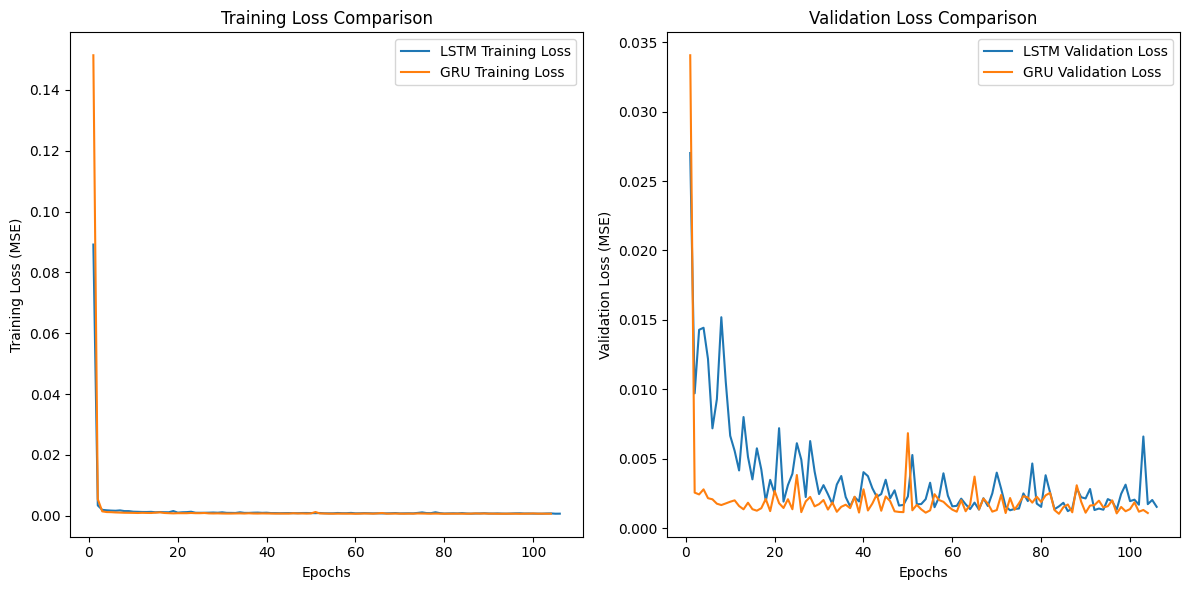

Validation Metrics:
LSTM -> MSE: 32.075296, MAE: 4.222828, MAPE: 2.28%
GRU  -> MSE: 22.710448, MAE: 3.471637, MAPE: 1.90%

Test Metrics:
LSTM -> MSE: 147.973989, MAE: 10.752945, MAPE: 4.59%
GRU  -> MSE: 48.196052, MAE: 5.197016, MAPE: 2.24%


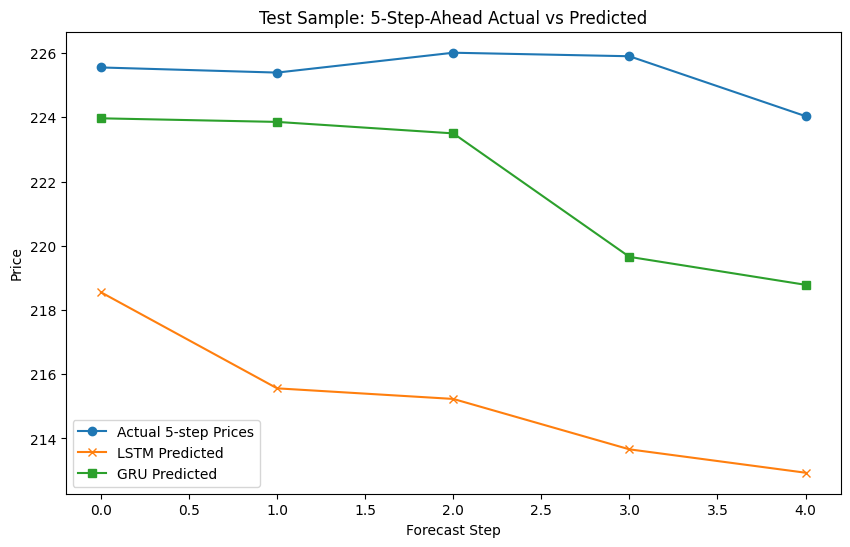

Out-of-Sample Forecast (first 10 predictions):
LSTM: [212.74432208 211.91111735 210.68391207 210.14099128 207.97184007
 204.28546486 202.77114711 202.00380029 201.40840075 200.12969477]
GRU:  [219.01552144 219.09142797 218.85034999 214.78115107 213.75511682
 214.57398284 214.9019742  213.85801628 210.4137688  209.08542159]


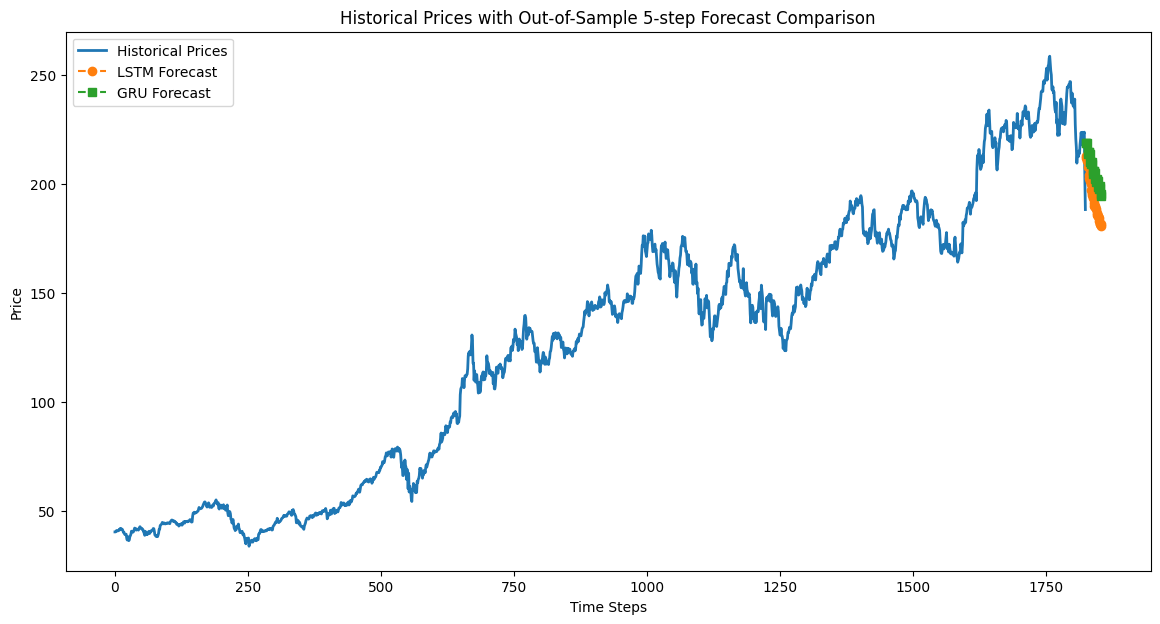

In [9]:

#############################################
# 11. Plot do histórico de treinamento (comparando os dois modelos)
#############################################
# Supondo que cada modelo armazene seu histórico em um dicionário "train_history".
epochs_lstm = np.arange(1, len(lstm_model.train_history["train_loss"]) + 1)
epochs_gru  = np.arange(1, len(gru_model.train_history["train_loss"]) + 1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs_lstm, lstm_model.train_history["train_loss"], label="LSTM Training Loss")
plt.plot(epochs_gru, gru_model.train_history["train_loss"], label="GRU Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Comparison")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_lstm, lstm_model.train_history["val_loss"], label="LSTM Validation Loss")
plt.plot(epochs_gru, gru_model.train_history["val_loss"], label="GRU Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss Comparison")
plt.legend()

plt.tight_layout()
plt.show()

#############################################
# 12. Denormalização, métricas para validação e teste
#############################################
def denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val) + min_val

# Obter previsões dos modelos para os conjuntos de validação e teste
pred_val_lstm_norm  = lstm_model.forward(X_val)   # Saída shape: (n_val, forecast_horizon)
pred_test_lstm_norm = lstm_model.forward(X_test)   # Shape: (n_test, forecast_horizon)

pred_val_gru_norm   = gru_model.forward(X_val)
pred_test_gru_norm  = gru_model.forward(X_test)

# Denormalizar previsões e alvos
pred_val_lstm  = denormalize(pred_val_lstm_norm, train_min, train_max)
pred_test_lstm = denormalize(pred_test_lstm_norm, train_min, train_max)
pred_val_gru   = denormalize(pred_val_gru_norm, train_min, train_max)
pred_test_gru  = denormalize(pred_test_gru_norm, train_min, train_max)

true_val  = denormalize(y_val, train_min, train_max)
true_test = denormalize(y_test, train_min, train_max)

def compute_metrics(true, pred):
    """
    Calcula MSE, MAE e MAPE sobre arrays que podem ter shape (n_samples, forecast_horizon)
    (Calcula a média sobre todos os elementos)
    """
    mse = np.mean((true - pred)**2)
    mae = np.mean(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred)/true)) * 100  # em porcentagem
    return mse, mae, mape

mse_val_lstm, mae_val_lstm, mape_val_lstm = compute_metrics(true_val, pred_val_lstm)
mse_test_lstm, mae_test_lstm, mape_test_lstm = compute_metrics(true_test, pred_test_lstm)
mse_val_gru, mae_val_gru, mape_val_gru = compute_metrics(true_val, pred_val_gru)
mse_test_gru, mae_test_gru, mape_test_gru = compute_metrics(true_test, pred_test_gru)

print("Validation Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_lstm, mae_val_lstm, mape_val_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_gru, mae_val_gru, mape_val_gru))
print("\nTest Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_lstm, mae_test_lstm, mape_test_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_gru, mae_test_gru, mape_test_gru))

#############################################
# 13. Plot: Preços reais vs. previstos (test set) para previsão de 5 passos
#############################################
# Para visualização, podemos escolher um exemplo (por exemplo, o primeiro exemplo do conjunto de teste).
sample_idx = 0
plt.figure(figsize=(10,6))
plt.plot(true_test[sample_idx], label="Actual 5-step Prices", marker='o')
plt.plot(pred_test_lstm[sample_idx], label="LSTM Predicted", marker='x')
plt.plot(pred_test_gru[sample_idx], label="GRU Predicted", marker='s')
plt.xlabel("Forecast Step")
plt.ylabel("Price")
plt.title("Test Sample: 5-Step-Ahead Actual vs Predicted")
plt.legend()
plt.show()

#############################################
# 14. Forecast Out-of-Sample (5-step-ahead recurrence)
#############################################
def forecast_multi(model, last_window, forecast_horizon, total_steps):
    """
    model: modelo treinado (lstm_model ou gru_model)
    last_window: array com shape (window_size, 1) – última janela (tamanho fixo, ex.: 24)
    forecast_horizon: número de passos previstos de cada vez (5)
    total_steps: quantos passos no total se deseja forecast (por exemplo, 30 ou 50)
    
    Para forecast multi-output recursivo, fazemos iterações onde:
      - Na cada iteração, o modelo prevê os próximos forecast_horizon valores.
      - Atualizamos a janela: descartamos os primeiros forecast_horizon valores e concatenamos os previstos.
      - Repetimos até atingir ou ultrapassar total_steps.
    Retorna um array com forecast realizado (trimado para total_steps elementos).
    """
    forecasted = []
    current_window = last_window.copy()  # shape: (window_size, 1)
    window_size = current_window.shape[0]
    num_iterations = int(np.ceil(total_steps / forecast_horizon))
    for _ in range(num_iterations):
        inp = current_window.reshape(1, window_size, 1)
        pred = model.forward(inp)  # saída shape: (1, forecast_horizon)
        pred = pred.reshape(forecast_horizon)
        forecasted.extend(pred.tolist())
        # Atualiza a janela: remove os primeiros forecast_horizon valores e anexa os previstos
        current_window = np.concatenate([current_window[forecast_horizon:], pred.reshape(-1, 1)], axis=0)
    forecasted = np.array(forecasted)[:total_steps]  # trim para total_steps
    return forecasted

total_forecast_steps = 30  # por exemplo, forecast para os próximos 30 passos
# Use a última janela do conjunto de teste
last_window = X_test[-1, :, 0].reshape(-1,1)  # shape: (24,1)
forecast_lstm_norm = forecast_multi(lstm_model, last_window, forecast_horizon, total_forecast_steps)
forecast_gru_norm  = forecast_multi(gru_model, last_window, forecast_horizon, total_forecast_steps)

forecast_lstm = denormalize(forecast_lstm_norm, train_min, train_max)
forecast_gru  = denormalize(forecast_gru_norm, train_min, train_max)

print("Out-of-Sample Forecast (first 10 predictions):")
print("LSTM:", forecast_lstm[:10])
print("GRU: ", forecast_gru[:10])

#############################################
# 15. Plot: Série histórica completa + Forecast Out-of-Sample (comparando os dois modelos)
#############################################
# Se full_series_norm não estiver definido, definimos a partir de price_series (a série completa)
full_series_norm = normalize(price_series, train_min, train_max)
full_series = denormalize(full_series_norm, train_min, train_max)

plt.figure(figsize=(14,7))
plt.plot(full_series, label="Historical Prices", linewidth=2)
forecast_x = np.arange(len(full_series), len(full_series) + total_forecast_steps)
plt.plot(forecast_x, forecast_lstm, label="LSTM Forecast", marker="o", linestyle="--")
plt.plot(forecast_x, forecast_gru,  label="GRU Forecast", marker="s", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.title("Historical Prices with Out-of-Sample 5-step Forecast Comparison")
plt.legend()
plt.show()

## Comparação: DEEPSEEK R1 + Google Colab   vs <i> Meu Código

Observacoes: 
- não conseguiu baixar dados, precisou do meu script
- gastou muitas tokens confuso com a data, alegando que estava em OCT2023
- nao conseguiu arch 
- cometeu erros como esquecer de definir tensorflow as tf

DEEPSEEK + CPU #########################

t= 2m44s, Cache: 2m02s

---------- Validation Metrics ----------

LSTM: MSE=36.2032, MAE=4.6534, MAPE=2.58%
GRU:  MSE=8.6351, MAE=2.1876, MAPE=1.21%

------------- Test Metrics -------------

LSTM: MSE=118.3025, MAE=7.8421, MAPE=3.48%
GRU:  MSE=25.0354, MAE=3.8469, MAPE=1.67%

DEEPSEEK + GPU T4 #########################

t=1m40s

---------- Validation Metrics ----------

LSTM: MSE=6.8676, MAE=1.9434, MAPE=1.08%
GRU:  MSE=8.0134, MAE=2.1039, MAPE=1.17%

------------- Test Metrics -------------

LSTM: MSE=28.2854, MAE=3.9482, MAPE=1.73%
GRU:  MSE=25.0192, MAE=4.0251, MAPE=1.74%

MEU CÓDIGO ###############################

t= 8 minutos só no treino

------------ Validation Metrics ----------------

LSTM -> MSE: 6.581023, MAE: 1.868890, MAPE: 1.02%
GRU  -> MSE: 6.662327, MAE: 1.878224, MAPE: 1.03%

-------------- Test Metrics: ---------------------

LSTM -> MSE: 25.328801, MAE: 4.234817, MAPE: 1.83%
GRU  -> MSE: 22.589413, MAE: 3.806204, MAPE: 1.65%


<b>Principais dificuldades: Confusão com os shapes dos dados de treinamento, fórmulas de dados descritivos, tempo de treinamento desconfortável, implementação de novas variáveis como "horizonte" extremamente laborioza, deveria ter incluído desde o início


# Convolutional Neural Network

        Treinando a Rede sobre o mesmo conjunto de dados

In [ ]:
##############################################################################################

# 7. defnnd a semnte para reprdt
SEED = 31415
np.random.seed(SEED)
print("Seed escolhida:", SEED)
######################################################################

# extrnd a sehre de prcs ajustd (como um arry numpy)
# supndo que o seu objto 'analyz' ja possi o mehtdo _get_p() que retrna uma pd.sers.
price_series = analyzer._get_price_series().values  # arry 1d de prcs
#################################################################################################

N = len(price_series)
###################################################################################

# 5. divso da sehre em 70% trenmn, 20% valdc, 10% teste
train_end = int(0.7 * N)
val_end   = train_end + int(0.2 * N)
##########################################################################

train_series = price_series[:train_end]
val_series   = price_series[train_end:val_end]
test_series  = price_series[val_end:]
#####################################################################################

# 8. normlz: usms os valrs minmo e maxmo do conjnt de trenmn para normlz toda a sehre para [0, 1]
train_min = np.min(train_series)
train_max = np.max(train_series)
###################################################################################################

def normalize(series, min_val, max_val):
    return (series - min_val) / (max_val - min_val)
####################################################################################################

train_norm = normalize(train_series, train_min, train_max)
val_norm   = normalize(val_series, train_min, train_max)
test_norm  = normalize(test_series, train_min, train_max)
############################################################################

print("----------------------")
print("normalizacoes feitas: (valor - min_val) / (max_val - min_val) ")
#################################################################

# funco para crir janls deslzn (windw_ = 24) para preprc dos dads
def create_sliding_windows(series, window_size=24, forecast_horizon=5):
    """
    para uma sehre 1d, gera um arry x com janls de tamnho windw_ 
    e um arry y com os proxms forcst valrs.
    """
    X = []
    y = []
    # garntr que haja forcst valrs apos a janla
    for i in range(len(series) - window_size - forecast_horizon + 1):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)
##################################################################################

# usndo as varvs ja defnds: tran_n, val_nr, test_n.
# se vc ja tinha defnd a divso para prevs de um unco passo, refca agra para prevs de 5 passs.
forecast_horizon = 1
X_train, y_train = create_sliding_windows(train_norm, window_size=24, forecast_horizon=forecast_horizon)
X_val, y_val     = create_sliding_windows(val_norm, window_size=24, forecast_horizon=forecast_horizon)
X_test, y_test   = create_sliding_windows(test_norm, window_size=24, forecast_horizon=forecast_horizon)
#############################################################################

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)
#################################################################################

###################################################################################

print("----------------------")
print("divisoes dos conjuntos:")
print("Training: X =", X_train.shape, "y =", y_train.shape)
print("Validation: X =", X_val.shape, "y =", y_val.shape)
print("Testing: X =", X_test.shape, "y =", y_test.shape)

Seed escolhida: 31415
----------------------
normalizacoes feitas: (valor - min_val) / (max_val - min_val) 
----------------------
divisoes dos conjuntos:
Training: X = (1253, 24, 1) y = (1253, 1)
Validation: X = (341, 24, 1) y = (341, 1)
Testing: X = (159, 24, 1) y = (159, 1)


In [ ]:
import numpy as np
#############################################################

# -----------------------
# camds do cnn
# -----------------------
##########################################################################

class Conv1D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size, self.stride, self.padding = kernel_size, stride, padding
        limit = np.sqrt(1/(in_channels * kernel_size))
        self.W = np.random.uniform(-limit, limit, (out_channels, in_channels, kernel_size))
        self.b = np.zeros(out_channels)
        # adam buffrs
        self.mW = np.zeros_like(self.W); self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b); self.vb = np.zeros_like(self.b)
        self.t = 0
        self.cache = None
##############################################################################

    def forward(self, x):
        # x: (batch, in_chn, length)
        batch, _, length = x.shape
        if self.padding > 0:
            x = np.pad(x, ((0,0),(0,0),(self.padding,self.padding)), constant_values=0)
            length += 2*self.padding
        out_length = (length - self.kernel_size)//self.stride + 1
        y = np.zeros((batch, self.out_channels, out_length))
        for i in range(out_length):
            seg = x[:, :, i*self.stride : i*self.stride + self.kernel_size]  # (batch, in_ch, k)
            # tensrd segmnt with w over axes (in_ch,k)
            y[:, :, i] = np.tensordot(seg, self.W, axes=([1,2],[1,2])) + self.b
        self.cache = x
        return y
##############################################################################################

    def backward(self, dy, lr):
        # dy: (batch, out_ch, out_ln)
        x = self.cache
        batch, _, length = x.shape
        _, _, out_length = dy.shape
##############################################################

        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dx = np.zeros_like(x)
############################################################

        for i in range(out_length):
            dy_i = dy[:, :, i]  # (batch, out_ch)
            seg = x[:, :, i*self.stride : i*self.stride + self.kernel_size]  # (batch, in_ch, k)
            # grad w, grad b
            for o in range(self.out_channels):
                dW[o] += np.tensordot(dy_i[:, o], seg, axes=[0,0])
            db += dy_i.sum(axis=0)
            # grad x
            for ic in range(self.in_channels):
                for k in range(self.kernel_size):
                    dx[:, ic, i*self.stride + k] += np.sum(
                        dy_i * self.W[:, ic, k],
                        axis=1
                    )
###############################################################

        # adam updte
        self.t += 1
        for param, grad, m, v in [
            (self.W, dW, self.mW, self.vW),
            (self.b, db, self.mb, self.vb)
        ]:
            m[:] = 0.9*m + 0.1*grad
            v[:] = 0.999*v + 0.001*(grad**2)
            m_hat = m/(1 - 0.9**self.t)
            v_hat = v/(1 - 0.999**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + 1e-8)
####################################################################################################

        # remvr paddng
        if self.padding > 0:
            return dx[:, :, self.padding:-self.padding]
        return dx
##################################################################

class ReLU:
    def __init__(self):
        self.mask = None
#################################################################################

    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
######################################################################

    def backward(self, dy):
        return dy * self.mask
####################################################################################################

class MaxPool1D:
    def __init__(self, pool_size=2):
        self.pool_size = pool_size
        self.cache = None
###############################################################################################

    def forward(self, x):
        # x: (batch, ch, length)
        b, c, L = x.shape
        out_L = L // self.pool_size
        y = x.reshape(b, c, out_L, self.pool_size).max(axis=3)
        self.cache = x
        return y
##################################################################

    def backward(self, dy):
        x = self.cache
        b, c, L = x.shape
        out_L = L // self.pool_size
        dx = np.zeros_like(x)
        x_r = x.reshape(b, c, out_L, self.pool_size)
        for i in range(self.pool_size):
            mask = (x_r == x_r.max(axis=3, keepdims=True))
            dx.reshape(b, c, out_L, self.pool_size)[..., i] += dy * mask[..., i]
        return dx
############################################################################################

class Flatten:
    def __init__(self):
        self.input_shape = None
######################################################################

    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)
####################################################################################################

    def backward(self, dy):
        return dy.reshape(self.input_shape)
###########################################################################################

class Dense:
    def __init__(self, in_size, out_size, activation='linear'):
        limit = np.sqrt(1/in_size)
        self.W = np.random.uniform(-limit, limit, (in_size, out_size))
        self.b = np.zeros(out_size)
        self.activation = activation
        self.mW = np.zeros_like(self.W); self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b); self.vb = np.zeros_like(self.b)
        self.t = 0
        self.x = None; self.z = None; self.mask = None
#############################################################

    def forward(self, x):
        self.x = x
        self.z = x.dot(self.W) + self.b
        if self.activation=='relu':
            self.mask = self.z>0
            return self.z * self.mask
        return self.z
########################################################################################

    def backward(self, dy, lr):
        dz = dy * (self.mask if self.activation=='relu' else 1)
        dW = self.x.T.dot(dz)
        db = dz.sum(axis=0)
        dx = dz.dot(self.W.T)
        # adam
        self.t +=1
        for p,g,m,v in [(self.W,dW,self.mW,self.vW),(self.b,db,self.mb,self.vb)]:
            m[:] = 0.9*m + 0.1*g
            v[:] = 0.999*v + 0.001*(g**2)
            m_hat = m/(1-0.9**self.t)
            v_hat = v/(1-0.999**self.t)
            p[:] -= 0.001 * m_hat/(np.sqrt(v_hat)+1e-8)
        return dx
#############################################################################################

class Dropout:
    def __init__(self, p):
        self.p = p; self.mask = None
#################################################################

    def forward(self, x, training=True):
        if training:
            self.mask = (np.random.rand(*x.shape)>self.p)/(1-self.p)
            return x * self.mask
        return x
##########################################################################

    def backward(self, dy):
        return dy * self.mask
###################################################################

class MSELoss:
    def __init__(self):
        self.pred = None; self.true = None
####################################################################################################

    def forward(self, pred, true):
        self.pred, self.true = pred, true
        return np.mean((pred-true)**2)
#############################################################

    def backward(self):
        return 2*(self.pred-self.true)/self.pred.shape[0]
#################################################################

# -----------------------
# modlo cnn1d
# -----------------------
###############################################################

class CNNModel:
    def __init__(self, window_size=24, output_size=1):
        self.conv1   = Conv1D(1, 64, kernel_size=3, padding=1)
        self.relu1   = ReLU()
        self.conv2   = Conv1D(64, 32, kernel_size=3, padding=1)
        self.relu2   = ReLU()
        self.pool    = MaxPool1D(pool_size=2)
        self.flatten = Flatten()
        self.fc1     = Dense((window_size//2)*32, 50, activation='relu')
        self.dropout = Dropout(0.2)
        self.fc2     = Dense(50, output_size, activation='linear')
        self.loss_fn = MSELoss()
###############################################################

    def forward(self, x, training=True):
        out = x.transpose(0,2,1)       # (batch,1,windw)
        out = self.conv1.forward(out)
        out = self.relu1.forward(out)
        out = self.conv2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool.forward(out)
        out = self.flatten.forward(out)
        out = self.fc1.forward(out)
        out = self.dropout.forward(out, training)
        return self.fc2.forward(out)
############################################################################

    def backward(self, grad):
        grad = self.fc2.backward(grad, lr=0.001)
        grad = self.dropout.backward(grad)
        grad = self.fc1.backward(grad, lr=0.001)
        grad = self.flatten.backward(grad)
        grad = self.pool.backward(grad)
        grad = self.relu2.backward(grad)
        grad = self.conv2.backward(grad, lr=0.001)
        grad = self.relu1.backward(grad)
        return self.conv1.backward(grad, lr=0.001)
##############################################################################################

    def train(self, X_train, y_train, X_val, y_val,
              epochs=200, batch_size=32, patience=10):
        best_val = np.inf
        counter = 0
        history = {'train_loss': [], 'val_loss': []}
        n = X_train.shape[0]
        for ep in range(1, epochs+1):
            perm = np.random.permutation(n)
            train_loss = 0
            for i in range(0, n, batch_size):
                idx = perm[i:i+batch_size]
                xb, yb = X_train[idx], y_train[idx]
                out = self.forward(xb, training=True)
                loss = self.loss_fn.forward(out, yb)
                train_loss += loss * xb.shape[0]
                grad = self.loss_fn.backward()
                self.backward(grad)
            train_loss /= n
            y_val_pred = self.forward(X_val, training=False)
            val_loss = self.loss_fn.forward(y_val_pred, y_val)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            print(f"Epoch {ep}: train={train_loss:.6f}, val={val_loss:.6f}")
            if val_loss < best_val:
                best_val = val_loss; counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Stopping at epoch", ep)
                    break
        return history

In [18]:
cnn_model = CNNModel(window_size=24, output_size=1)
history_cnn = cnn_model.train(X_train, y_train, X_val, y_val)


Epoch 1: train=0.032093, val=0.002848
Epoch 2: train=0.006803, val=0.006265
Epoch 3: train=0.006673, val=0.003192
Epoch 4: train=0.005836, val=0.004203
Epoch 5: train=0.005526, val=0.004048
Epoch 6: train=0.005638, val=0.011515
Epoch 7: train=0.004764, val=0.003564
Epoch 8: train=0.004680, val=0.007487
Epoch 9: train=0.004657, val=0.002484
Epoch 10: train=0.004024, val=0.001493
Epoch 11: train=0.004466, val=0.003841
Epoch 12: train=0.004317, val=0.008380
Epoch 13: train=0.004289, val=0.000967
Epoch 14: train=0.003829, val=0.002463
Epoch 15: train=0.004053, val=0.002742
Epoch 16: train=0.003803, val=0.000822
Epoch 17: train=0.003466, val=0.000851
Epoch 18: train=0.003754, val=0.001589
Epoch 19: train=0.003390, val=0.002660
Epoch 20: train=0.003864, val=0.004068
Epoch 21: train=0.004594, val=0.000632
Epoch 22: train=0.003385, val=0.001139
Epoch 23: train=0.003469, val=0.000532
Epoch 24: train=0.003441, val=0.007124
Epoch 25: train=0.003409, val=0.002962
Epoch 26: train=0.003293, val=0.00

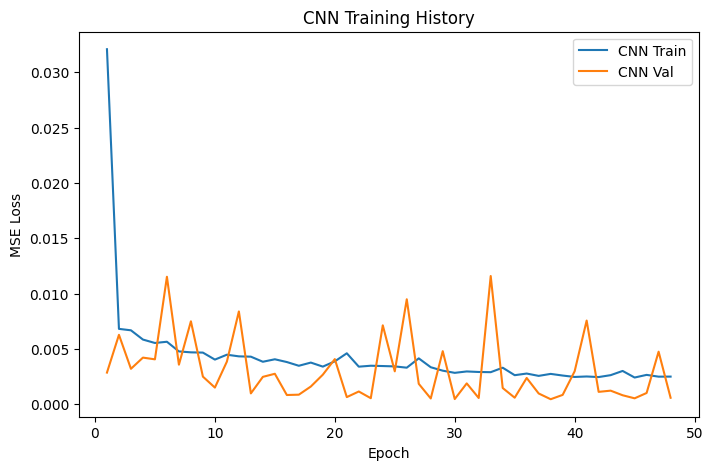

CNN Validation →  MSE: 12.016634, MAE: 2.659689, MAPE: 1.44%
CNN Test       →  MSE: 40.723816, MAE: 5.532709, MAPE: 2.39%


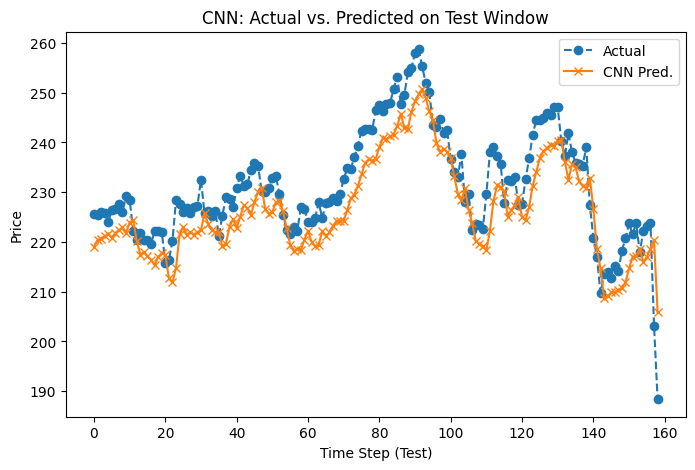

CNN 30-Day Forecast (primeiros 10): [205.93039707 202.75886614 202.13528887 203.12281624 202.1565995
 200.61848489 198.78558224 196.45901415 194.05399686 191.12761899]


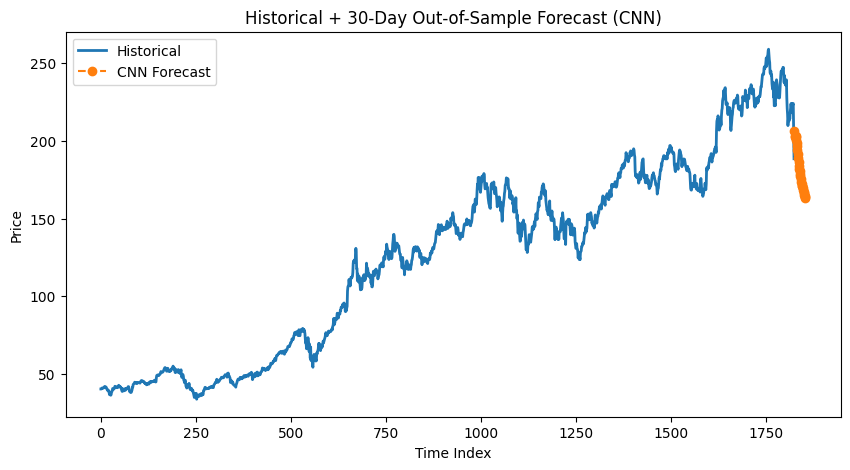


=== Comparação de Métricas ===
Validation Metrics:
LSTM -> MSE: 32.075296, MAE: 4.222828, MAPE: 2.28%
GRU  -> MSE: 22.710448, MAE: 3.471637, MAPE: 1.90%
CNN  ->  MSE: 12.016634, MAE: 2.659689, MAPE: 1.44%

Test Metrics:
LSTM -> MSE: 147.973989, MAE: 10.752945, MAPE: 4.59%
GRU  -> MSE: 48.196052, MAE: 5.197016, MAPE: 2.24%
CNN  ->  MSE: 40.723816, MAE: 5.532709, MAPE: 2.39%


In [ ]:

#################################################################################

# ————————————————————————————————————————————————————————————————————
# funcs auxlrs
# ————————————————————————————————————————————————————————————————————
##################################################################################################

def denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val) + min_val
#######################################################################################

def normalize(series, min_val, max_val):
    return (series - min_val) / (max_val - min_val)
################################################################

def compute_metrics(true, pred):
    mse  = np.mean((true - pred)**2)
    mae  = np.mean(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred)/true)) * 100
    return mse, mae, mape
###################################################################################

def forecast(model, last_window, steps):
    """
    prevs recrsv 1-step-ahed:
      last_w: arry (windw_,1)
      stps: qunts passs a frnte
    """
    preds = []
    w = last_window.copy()
    ws = w.shape[0]
    for _ in range(steps):
        inp = w.reshape(1, ws, 1)
        p = model.forward(inp, training=False)[0, 0]
        preds.append(p)
        w = np.concatenate([w[1:], [[p]]], axis=0)
    return np.array(preds)
##########################################################################

# ————————————————————————————————————————————————————————————————————
# 8. plot do histrc de trenmn do cnn
#    (histry vindo de: histry = cnn_md.tran(...))
# ————————————————————————————————————————————————————————————————————
epochs_cnn = np.arange(1, len(history_cnn['train_loss']) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs_cnn, history_cnn['train_loss'], label='CNN Train')
plt.plot(epochs_cnn, history_cnn['val_loss'] , label='CNN Val')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN Training History")
plt.legend()
plt.show()
###############################################################################################

# ————————————————————————————————————————————————————————————————————
# 9. forcst one step ahed (valdc e teste)
# ————————————————————————————————————————————————————————————————————
pred_val_cnn_norm  = cnn_model.forward(X_val,   training=False)  # (n_vl,1)
pred_test_cnn_norm = cnn_model.forward(X_test,  training=False)  # (n_tst,1)
#########################################################################

# ————————————————————————————————————————————————————————————————————
# 10. denrml + mehtrc para valdc e teste
# ————————————————————————————————————————————————————————————————————
pred_val_cnn  = denormalize(pred_val_cnn_norm, train_min, train_max)
pred_test_cnn = denormalize(pred_test_cnn_norm, train_min, train_max)
true_val      = denormalize(y_val,             train_min, train_max)
true_test     = denormalize(y_test,            train_min, train_max)
##########################################################################

mse_val_c, mae_val_c, mape_val_c = compute_metrics(true_val, pred_val_cnn)
mse_te_c,  mae_te_c,  mape_te_c  = compute_metrics(true_test, pred_test_cnn)
########################################################################

print("CNN Validation ?  MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_c, mae_val_c, mape_val_c))
print("CNN Test       ?  MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_te_c,  mae_te_c,  mape_te_c))
#####################################################################################

# ————————————————————————————————————————————————————————————————————
#######################################################################################

# ————————————————————————————————————————————————————————————————————
# 11. plot: actl vs. predct (cnn) na janla de teste
# ————————————————————————————————————————————————————————————————————
plt.figure(figsize=(8,5))
plt.plot(true_test,      label='Actual',    marker='o', linestyle='--')
plt.plot(pred_test_cnn,  label='CNN Pred.', marker='x', linestyle='-')
plt.xlabel("Time Step (Test)")
plt.ylabel("Price")
plt.title("CNN: Actual vs. Predicted on Test Window")
plt.legend()
plt.show()
########################################################################################

# ————————————————————————————————————————————————————————————————————
# 12. out-of-sample forcst (proxms 30 dias)
# ————————————————————————————————————————————————————————————————————
forecast_steps = 30
last_window = X_test[-1,:,0].reshape(-1,1)
f_cnn_norm = forecast(cnn_model, last_window, forecast_steps)
f_cnn      = denormalize(f_cnn_norm, train_min, train_max)
###################################################################

print("CNN 30-Day Forecast (primeiros 10):", f_cnn[:10])
##############################################################################################

# ————————————————————————————————————————————————————————————————————
# 13. plot: sehre histrc + forcst cnn
# ————————————————————————————————————————————————————————————————————
full_norm   = normalize(price_series, train_min, train_max)
full_series = denormalize(full_norm, train_min, train_max)
forecast_x  = np.arange(len(full_series), len(full_series)+forecast_steps)
###############################################################################################

plt.figure(figsize=(10,5))
plt.plot(full_series,           label='Historical', linewidth=2)
plt.plot(forecast_x, f_cnn,     label='CNN Forecast', marker='o', linestyle='--')
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.title("Historical + 30-Day Out-of-Sample Forecast (CNN)")
plt.legend()
plt.show()
#########################################################################

# ————————————————————————————————————————————————————————————————————
# 14. comprc finl de mehtrc: lstm vs gru vs cnn
# ————————————————————————————————————————————————————————————————————


print("\n=== Comparação de Métricas ===")
###############################################################################

print("Validation Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_lstm, mae_val_lstm, mape_val_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_gru, mae_val_gru, mape_val_gru))
print("CNN  ->  MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_val_c, mae_val_c, mape_val_c))
print("\nTest Metrics:")
print("LSTM -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_lstm, mae_test_lstm, mape_test_lstm))
print("GRU  -> MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_test_gru, mae_test_gru, mape_test_gru))
print("CNN  ->  MSE: {:.6f}, MAE: {:.6f}, MAPE: {:.2f}%".format(mse_te_c,  mae_te_c,  mape_te_c))

# Outras Previsões

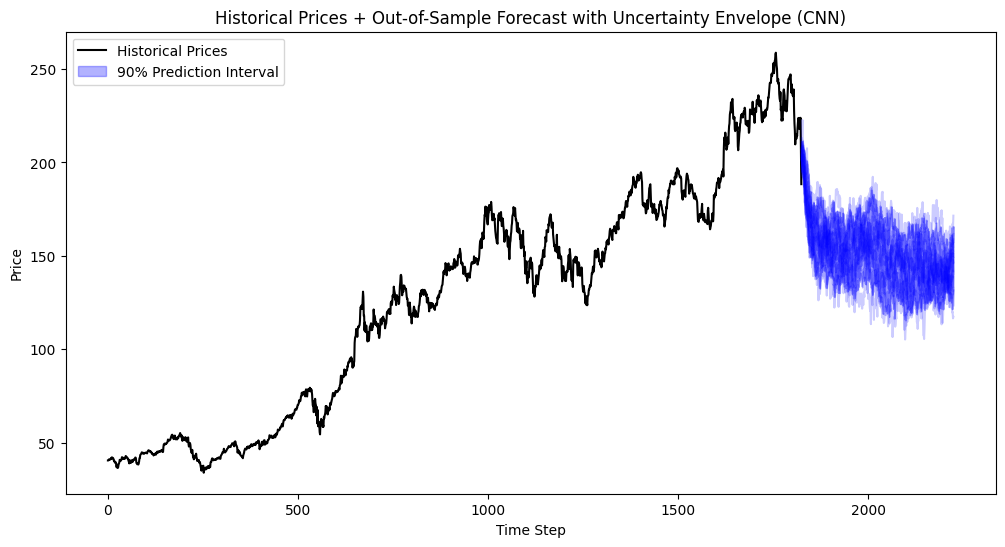

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
############################################################################################

# ————————————————————————————————————————————————————————————————————
# simlc de multpl trajtr com rudo
# ————————————————————————————————————————————————————————————————————
##############################################################################

def simulate_paths(model, last_window, steps, n_paths, sigma_norm):
    """
    simla n_pths trajtr de forcst recrsv com adco de rudo.
    - modl: modlo trend que possa mehtdo forwrd()
    - last_w: arry (windw_, 1) normlz
    - stps: numro de passs futrs a simlr
    - n_pths: qunts trajtr
    - sigm_n: desvo-padro do rudo na escla normlz
    retrna: np.arry(shpe=(n_pths, stps)) com trajtr normlz
    """
    window_size = last_window.shape[0]
    paths = np.zeros((n_paths, steps))
    for i in range(n_paths):
        w = last_window.copy()
        for t in range(steps):
            pred = model.forward(w.reshape(1, window_size, 1), training=False)[0,0]
            noise = np.random.normal(0, sigma_norm)
            val = pred + noise
            paths[i, t] = val
            w = np.vstack([w[1:], [[val]]])
    return paths
######################################################################

# ————————————————————————————————————————————————————————————————————
# calclo do rudo emprc e simlc
# ————————————————————————————————————————————————————————————————————
# ajste para seu modlo: aqui usms cnn_md como exmplo
pred_test_norm = cnn_model.forward(X_test, training=False).flatten()
residuals_norm = pred_test_norm - y_test.flatten()
sigma_norm = np.std(residuals_norm)
############################################################################

n_paths = 20
forecast_steps = 400
last_window_norm = X_test[-1, :, 0].reshape(-1, 1)
#############################################################

paths_norm = simulate_paths(cnn_model, last_window_norm, forecast_steps, n_paths, sigma_norm)
######################################################################

# denrml das trajtr
def denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val) + min_val
#################################################################################

paths = denormalize(paths_norm, train_min, train_max)
####################################################################################

# sehre histrc complt denrml
full_norm = normalize(price_series, train_min, train_max)
full_series = denormalize(full_norm, train_min, train_max)
###################################################################################

# ————————————————————————————————————————————————————————————————————
# plot ovrly: histrc + trajtr + envlp de incrtz
# ————————————————————————————————————————————————————————————————————
plt.figure(figsize=(12,6))
###############################################################################################

# plot da sehre histrc
x_hist = np.arange(len(full_series))
plt.plot(x_hist, full_series, label='Historical Prices', color='black')
#####################################################################################

# eixo de tempo para forcst
x_fore = np.arange(len(full_series), len(full_series) + forecast_steps)
##############################################################################################

# plot de cada trajtr
for i in range(n_paths):
    plt.plot(x_fore, paths[i], color='blue', alpha=0.2)
##########################################################################

# calclo do envlp (percnt)
lower = np.percentile(paths, 5, axis=0)
upper = np.percentile(paths, 95, axis=0)
################################################################

# prench do envlp de 90%
plt.fill_between(x_fore, lower, upper, color='blue', alpha=0.3, label='90% Prediction Interval')
########################################################################

plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Historical Prices + Out-of-Sample Forecast with Uncertainty Envelope (CNN)")
plt.legend()
plt.show()

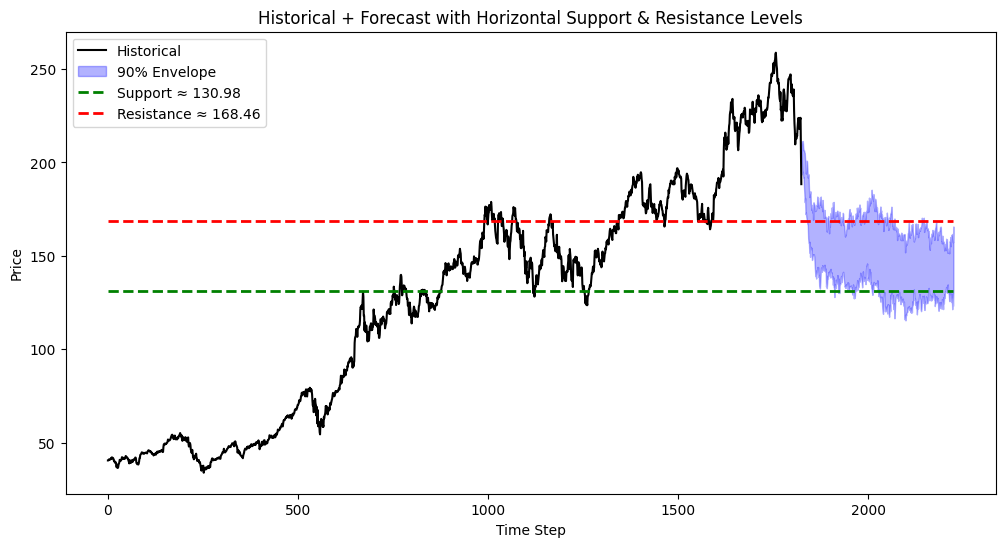

In [ ]:

# 1) calclr envlp de incrtz (5% e 95%) — arry shpe (n_stps,)
lower = np.percentile(paths, 5, axis=0)
upper = np.percentile(paths, 95, axis=0)
############################################################

# 2) defnr nivs horznt de suprte e resstn
#    aqui usms os qunts mehds ao longo do tempo
support_level     = np.median(lower)   # nivl de suprte
resistance_level  = np.median(upper)   # nivl de resstn
#####################################################################

# 3) montr o eixo x complt (histrc + prevs)
n_hist = len(full_series)
n_steps = paths.shape[1]
x_full = np.arange(n_hist + n_steps)
################################################################

# 4) plot histrc + envlp + linhs horznt
plt.figure(figsize=(12,6))
###############################################################################################

# sehre histrc
plt.plot(np.arange(n_hist), full_series, 'k-', label='Historical')
#############################################################

# envlp de incrtz sobre a area de forcst
forecast_x = np.arange(n_hist, n_hist + n_steps)
plt.fill_between(forecast_x, lower, upper, color='blue', alpha=0.3, label='90% Envelope')
########################################################################################

# linhs horznt de suprte e resstn
plt.hlines(support_level, 0, n_hist + n_steps - 1, colors='green', linestyle='--', linewidth=2, label=f'Support ˜ {support_level:.2f}')
plt.hlines(resistance_level, 0, n_hist + n_steps - 1, colors='red',   linestyle='--', linewidth=2, label=f'Resistance ˜ {resistance_level:.2f}')
####################################################################

plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Historical + Forecast with Horizontal Support & Resistance Levels")
plt.legend()
plt.show()

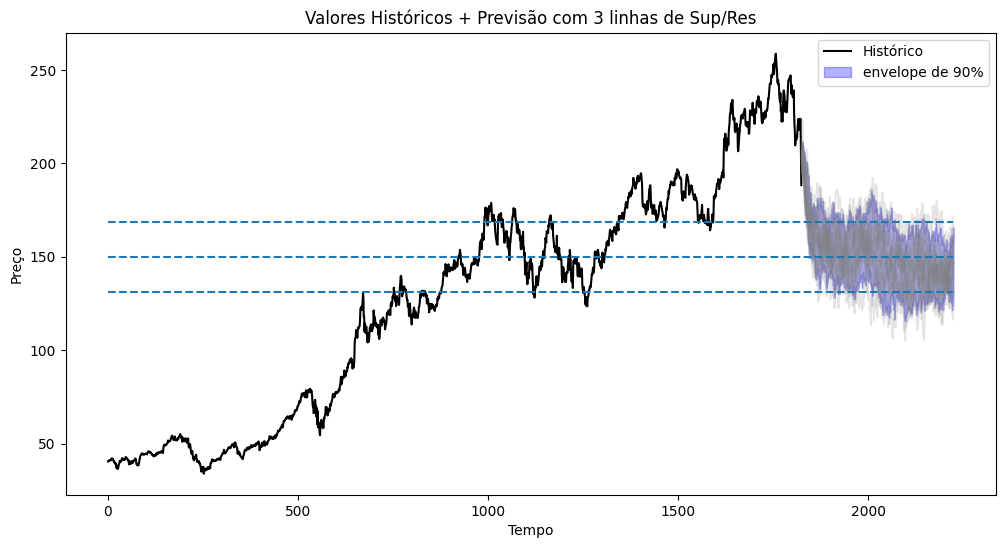

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
########################################################################################

def plot_with_horizontal_levels(full_series, paths, train_min, train_max,
                                lower_pct=5, upper_pct=95, n_levels=5):
    """
    plta a sehre histrc + envlp de forcst + trajtr simlds,
    e desnha n_lvls linhs horznt espcds entre os nivs de suprte
    e resstn esttst (medns dos percnt lowr_p e uppr_p).
##################################################################################################

    full_s : arry 1d denrml da sehre histrc
    paths       : arry shpe (n_pths, n_stps) com trajtr simlds denrml
    tran_m   : valr minmo usdo na normlz
    tran_m   : valr maxmo usdo na normlz
    lowr_p   : percnt infrr do envlp (ex: 5)
    uppr_p   : percnt suprr do envlp (ex: 95)
    n_lvls    : qunts linhs horznt desnhr
    """
    n_hist  = len(full_series)
    n_steps = paths.shape[1]
    x_hist  = np.arange(n_hist)
    x_fore  = np.arange(n_hist, n_hist + n_steps)
#################################################################################################

    # envlp de incrtz
    lower = np.percentile(paths, lower_pct, axis=0)
    upper = np.percentile(paths, upper_pct, axis=0)
###########################################################################################

    # nivs de suprte e resstn esttst
    support_level    = np.median(lower)
    resistance_level = np.median(upper)
###############################################################################################

    # gerndo n_lvls valrs entre suprte e resstn
    levels = np.linspace(support_level, resistance_level, n_levels)
######################################################################################

    plt.figure(figsize=(12,6))
    # sehre histrc
    plt.plot(x_hist, full_series, color='black', label='Histórico')
###############################################################################################

    # trajtr simlds
    for p in paths:
        plt.plot(x_fore, p, color='gray', alpha=0.2)
#########################################################################

    # envlp de forcst
    plt.fill_between(x_fore, lower, upper, color='blue', alpha=0.3, label=f'envelope de {upper_pct - lower_pct}%')
##################################################################################

    # linhs horznt
    for lvl in levels:
        plt.hlines(lvl, xmin=0, xmax=n_hist + n_steps - 1, linestyles='--')
###########################################################################################

    plt.xlabel("Tempo")
    plt.ylabel("Preço")
    plt.title(f"Valores Históricos + Previsão com {n_levels} linhas de Sup/Res")
    plt.legend()
    plt.show()
############################################################

######################################################################

# exmplo de uso (nao exectr este snppt, apns copr para o seu notbk):
# full_n   = normlz(pric_s, tran_m, tran_m)
# full_s = denrml(full_n, tran_m, tran_m)
# paths       = ...         # suas trajtr simlds denrml
plot_with_horizontal_levels(full_series, paths, train_min, train_max,
                            lower_pct=5, upper_pct=95, n_levels=3)
#######################################################################################
